In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import log_loss
from sklearn.metrics import brier_score_loss
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns


/home/cs20btech11063/anaconda3/envs/gpu_env2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Read the CSV file
df = pd.read_csv('costsensitiveregression.csv')

# apply log transform and add 1 to avoid log(0) to FNC column
# df['FNC'] = np.log(df['FNC'] + 1)

# Separate the independent variables (X) and the dependent variable (y)
X = df.iloc[:, :11]
y = df.iloc[:, 11:13]

# Dropping the YesCount column as it is correlated to NoCount
X.drop('YesCount', axis=1, inplace=True)

print("X Column types:\n", X.dtypes)
print("Y Column types:\n", y.dtypes)

# print the frequency of Status values from df
print("Frequency counts of Status:\n", df['Status'].value_counts())

# Split the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.4, random_state=42)


# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train.to_numpy(), dtype=torch.float32)
y_val = torch.tensor(y_val.to_numpy(), dtype=torch.float32)
y_test = torch.tensor(y_test.to_numpy(), dtype=torch.float32)

# Pretty print all the shapes in one line
print("X_train: ", X_train.shape, "y_train: ", y_train.shape, "X_val: ", X_val.shape, "y_val: ", y_val.shape, "X_test: ", X_test.shape, "y_test: ", y_test.shape)

# Create a custom dataset
class CSLogRegDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create DataLoader objects for training and testing
train_dataset = CSLogRegDataset(X_train, y_train)
val_dataset = CSLogRegDataset(X_val, y_val)
test_dataset = CSLogRegDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


X Column types:
 NotCount      int64
ATPM        float64
PFD         float64
PFG         float64
SFD         float64
SFG         float64
WP          float64
WS          float64
AH          float64
AN          float64
dtype: object
Y Column types:
 Status      int64
FNC       float64
dtype: object
Frequency counts of Status:
 0    103554
1     44082
Name: Status, dtype: int64
X_train:  torch.Size([103345, 10]) y_train:  torch.Size([103345, 2]) X_val:  torch.Size([26574, 10]) y_val:  torch.Size([26574, 2]) X_test:  torch.Size([17717, 10]) y_test:  torch.Size([17717, 2])


In [3]:
# def describe_to_latex(df):
#     table = "\\begin{table}[!ht]\n"
#     table += "\\centering\n"
#     table += "\\caption{Descriptive Statistics}\n"
#     table += "\\label{tab:descriptive_statistics}\n"
#     table += "\\begin{tabular}{l" + "c" * len(df.columns) + "}\n"
#     table += "\\hline\n"
#     table += " & ".join([""] + df.columns.tolist()) + " \\\\ \\hline\n"

#     for index, row in df.iterrows():
#         table += index
#         for value in row:
#             table += " & " + "{:.2f}".format(value)
#         table += " \\\\\n"

#     table += "\\hline\n"
#     table += "\\end{tabular}\n"
#     table += "\\end{table}\n"
#     return table

# describe_latex = describe_to_latex(df.describe(percentiles=[]))
# print(describe_latex)

print(df.describe(percentiles=[]))

print(df.info(verbose=True, memory_usage='deep', show_counts=True))

# def describe_to_latex_transposed(df):
#     table = "\\begin{table}[!ht]\n"
#     table += "\\centering\n"
#     table += "\\caption{Descriptive Statistics}\n"
#     table += "\\label{tab:descriptive_statistics}\n"
#     table += "\\begin{tabular}{l" + "c" * len(df.index) + "}\n"
#     table += "\\hline\n"
#     table += " & ".join([""] + ["\\textbf{" + x + "}" for x in df.index.tolist()]) + " \\\\ \\hline\n"

#     for column in df.columns:
#         table += "\\textbf{" + column + "}"
#         for index, row in df.iterrows():
#             table += " & " + "{:.2f}".format(row[column])
#         table += " \\\\\n"

#     table += "\\hline\n"
#     table += "\\end{tabular}\n"
#     table += "\\end{table}\n"
#     return table
# describe_latex_transposed = describe_to_latex_transposed(df[['FNC']].describe())
# print(describe_latex_transposed)

# check if data has missing values
print(df.isnull().sum())


            NotCount       YesCount           ATPM            PFD  \
count  147636.000000  147636.000000  147636.000000  147636.000000   
mean        7.722107      15.220908       0.253245       0.027062   
std         7.574278       7.596921       0.366280       0.335509   
min         0.000000       0.000000       0.000000       0.000000   
50%         4.000000      19.000000       0.033354       0.000000   
max        23.000000      22.000000       1.000000      79.837480   

                 PFG            SFD            SFG             WP  \
count  147636.000000  147636.000000  147636.000000  147636.000000   
mean        0.050789       0.021648       0.071709       0.271927   
std         0.373370       0.298285       1.135755       2.432425   
min         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
max        51.944780      61.556900     209.021870     399.606420   

                  WS            

In [4]:
# Describe the FNC column
fnc_df = df['FNC']
fnc_df = fnc_df.round().astype(int)
# describe the fnc_df
print(fnc_df.describe())

count    1.476360e+05
mean     5.333955e+02
std      8.774013e+03
min      0.000000e+00
25%      0.000000e+00
50%      1.200000e+01
75%      1.070000e+02
max      1.703186e+06
Name: FNC, dtype: float64


In [5]:
# # make scatter plot of the new_df
# # tmp_df is first 1000 rows of new_df
# tmp_df = fnc_df[10000:140000]
# plt.scatter(tmp_df.index, tmp_df)

# plt.show()

# # fit fnc_df to a normal distribution
# from scipy.stats import norm
# mu, std = norm.fit(fnc_df)
# print(mu, std)

# # plot the histogram of fnc_df
# plt.figure(figsize=(10, 6))
# plt.hist(fnc_df, bins=25, density=True, alpha=0.6, color='g')

# # plot the PDF of the normal distribution
# xmin, xmax = plt.xlim()
# print(xmin, xmax)
# x = np.linspace(xmin, xmax, 100)
# p = norm.pdf(x, mu, std)
# plt.plot(x, p, 'k', linewidth=2)
# title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
# plt.title(title)
# # plt.xlim(-1, 140000)
# plt.show()


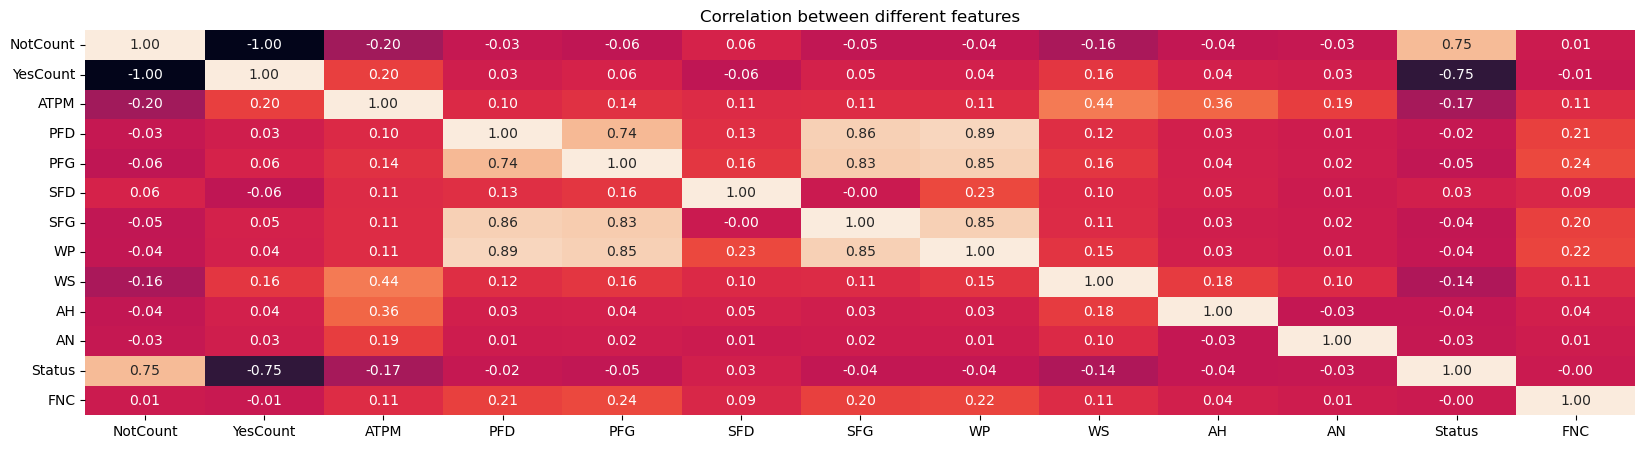

In [6]:
correlation_train = df.corr("pearson")
# plot correlation_train
fig = plt.figure(figsize=(20, 5))
# sns.heatmap(correlation_train, vmax=1, annot=True, cmap='cubehelix', annot_kws={'size': 14}, fmt='.2f', linewidths=.5)
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
# plt.title('Correlation between different features', fontsize=14)
sns.heatmap(correlation_train, vmax=1, annot=True, cbar=False, fmt='.2f')
plt.title('Correlation between different features')
plt.show()
plt.close()

In [7]:
class CostSensitiveLogisticRegression(nn.Module):
    def __init__(self, input_dim):
        super(CostSensitiveLogisticRegression, self).__init__()   
        # Defining the number of input features
        self.input_dim = input_dim
        # Defining the number of output features
        self.output_dim = 1
        self.model = nn.Sequential(
            nn.Linear(input_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        out = self.model(x)
        return out

    def compute_loss(self, y_pred, y_true, false_negative_cost):
        epsilon = 1e-7
        true_positive_cost = 4.0
        false_positive_cost = 4.0
        true_negative_cost = 0
        # print("False Negative Cost: ",false_negative_cost.reshape(-1,1).shape)
        
        # print("Y_pred Shape: ",y_pred.shape)
        # print("Y_true Shape: ",y_true.shape)

        # Compute the losses for true positives, false positives, true negatives, and false negatives
        # tp_loss = y_true * torch.log(y_pred + epsilon) * true_positive_cost
        # fp_loss = y_true * torch.log(1 - y_pred + epsilon) * false_positive_cost
        # tn_loss = (1 - y_true) * torch.log(1 - y_pred + epsilon) * true_negative_cost
        # fn_loss = (1 - y_true) * torch.log(y_pred + epsilon) * false_negative_cost
        
        tp_loss = y_true * y_pred * true_positive_cost
        fp_loss = (1 - y_true) * y_pred * false_positive_cost
        fn_loss = (y_true * (1 - y_pred)) * false_negative_cost.reshape(-1,1)
        # tn_loss = (1 - y_true) * (1 - y_pred) * true_negative_cost
        tn_loss = torch.multiply((1 - y_true), (1 - y_pred)) * true_negative_cost
        # print((1-y_true).shape)
        # print((1-y_pred).shape)

        # Compute the total loss
        # total_loss = y_true * (y_pred * true_positive_cost + (1 - y_pred) * false_negative_cost) + (1 - y_true) * (y_pred * false_positive_cost + (1 - y_pred) * true_negative_cost)

        # total_loss = total_loss.mean()
        total_loss = tp_loss + fp_loss + tn_loss + fn_loss
        # print(tp_loss.shape, fp_loss.shape, tn_loss.shape, fn_loss.shape)
        # print("Loss Shape: ",total_loss.shape)
        total_loss = total_loss.mean()

        return total_loss
    
    def compute_expected_cost(self, test_loader):
        # compute the expected cost for the test data
        total_cost = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = self(data)
            false_neg_cost = target[:, 1]
            target = target[:, 0].view(-1, 1)
            loss = self.compute_loss(output, target, false_neg_cost)
            total_cost += loss.item() * data.size(0)
        return total_cost
    
    def train_model(self, train_loader, test_loader, optimizer, num_epochs=10, learning_rate=0.001):
        # Define the loss function and the optimizer
        criterion = self.compute_loss
        # optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        # optimizer = optimizer
        
        self.train()

        # Lists to keep track of progress
        train_losses = []
        test_losses = []
        test_accuracies = []
        train_accuracies = []
        best_accuracy = 0
        best_model = None

        # Number of epochs
        n_epochs = num_epochs

        for epoch in range(n_epochs):
            # Monitor training loss
            train_loss = 0.0
            total_classified = 0
            correct_classified = 0
            self.train()
            # self.train()
            for batch_idx, (data, target) in enumerate(train_loader):
                # Clear the gradients of all optimized variables
                optimizer.zero_grad()
                # Forward pass: compute predicted outputs by passing inputs to the model
                output = self(data)
                false_neg_cost = target[:, 1]
                target = target[:, 0].view(-1, 1)
                # Calculate the batch loss
                loss = criterion(output, target, false_neg_cost)
                # Backward pass: compute gradient of the loss with respect to model parameters
                loss.backward()
                # Perform a single optimization step (parameter update)
                optimizer.step()
                # Update running training loss
                train_loss += loss.item() * data.size(0)
                # Calculate the number of correct classifications
                pred = output >= 0.5
                correct_classified += (pred == target).sum().item()
                total_classified += len(target)               
            

            # Calculate average loss over an epoch
            train_loss = train_loss / len(train_loader.dataset)
            
            # Calculate training accuracy
            train_accuracy = correct_classified / total_classified
        
            # Append to the training loss and accuracy lists
            train_accuracies.append(train_accuracy)
            train_losses.append(train_loss)

            # Test the model for validation
            test_loss = 0.0
            total_classified = 0
            correct_classified = 0
            self.eval()
            for batch_idx, (data, target) in enumerate(test_loader):
                # Forward pass: compute predicted outputs by passing inputs to the model
                output = self(data)
                false_neg_cost = target[:, 1]
                target = target[:, 0].view(-1, 1)
                # Calculate the batch loss
                loss = criterion(output, target, false_neg_cost)
                # Update running validation loss 
                test_loss += loss.item() * data.size(0)
                # Calculate the number of correct classifications
                pred = output >= 0.5
                correct_classified += (pred == target).sum().item()
                total_classified += len(target)
        
            # Calculate average loss over an epoch
            test_loss = test_loss / len(test_loader.dataset)
        
            # Calculate validation accuracy
            test_accuracy = correct_classified / total_classified
            
            # Append to the validation loss and accuracy lists
            test_accuracies.append(test_accuracy)
            test_losses.append(test_loss)
        
            # print both test and train loss and accuracy
            print('Epoch: {} \tTraining Loss: {:.6f} \tTraining Accuracy: {:.6f} \tValidation Loss: {:.6f} \tValidation Accuracy: {:.6f}'.format(epoch+1, train_loss, train_accuracy, test_loss, test_accuracy))
        
            if test_accuracy > best_accuracy:
                best_accuracy = test_accuracy
                # best_model = self.state_dict()
                # torch.save(best_model, 'best_model.pt')
                torch.save(self.state_dict(), 'best_model.pt')
                
        # print('Best Accuracy: ', best_accuracy)
        # Load the best model
        self.load_state_dict(torch.load('best_model.pt'))
        return train_losses, test_losses, train_accuracies, test_accuracies, best_accuracy, best_model
    
    def train_model2(self, train_loader, test_loader, optimizer, num_epochs=10, learning_rate=0.001):
        # Define the loss function and the optimizer
        criterion = self.compute_loss
        # optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        # optimizer = optimizer
        
        self.train()

        # Lists to keep track of progress
        train_losses = []
        test_losses = []
        test_accuracies = []
        train_accuracies = []
        best_expected_cost = float('inf')
        best_model = None

        # Number of epochs
        n_epochs = num_epochs

        for epoch in range(n_epochs):
            # Monitor training loss
            train_loss = 0.0
            total_classified = 0
            correct_classified = 0
            self.train()
            # self.train()
            for batch_idx, (data, target) in enumerate(train_loader):
                # Clear the gradients of all optimized variables
                optimizer.zero_grad()
                # Forward pass: compute predicted outputs by passing inputs to the model
                output = self(data)
                false_neg_cost = target[:, 1]
                target = target[:, 0].view(-1, 1)
                # Calculate the batch loss
                loss = criterion(output, target, false_neg_cost)
                # Backward pass: compute gradient of the loss with respect to model parameters
                loss.backward()
                # Perform a single optimization step (parameter update)
                optimizer.step()
                # Update running training loss
                train_loss += loss.item() * data.size(0)
                # Calculate the number of correct classifications
                pred = output >= 0.5
                correct_classified += (pred == target).sum().item()
                total_classified += len(target)               
            

            # Calculate average loss over an epoch
            train_loss = train_loss / len(train_loader.dataset)
            
            # Calculate training accuracy
            train_accuracy = correct_classified / total_classified
        
            # Append to the training loss and accuracy lists
            train_accuracies.append(train_accuracy)
            train_losses.append(train_loss)
            
            # Test the model for validation
            test_loss = 0.0
            total_classified = 0
            correct_classified = 0
            self.eval()
            for batch_idx, (data, target) in enumerate(test_loader):
                # Forward pass: compute predicted outputs by passing inputs to the model
                output = self(data)
                false_neg_cost = target[:, 1]
                target = target[:, 0].view(-1, 1)
                # Calculate the batch loss
                loss = criterion(output, target, false_neg_cost)
                # Update running validation loss 
                test_loss += loss.item() * data.size(0)
                # Calculate the number of correct classifications
                pred = output >= 0.5
                correct_classified += (pred == target).sum().item()
                total_classified += len(target)
        
            # Calculate average loss over an epoch
            test_loss = test_loss / len(test_loader.dataset)
        
            # Calculate validation accuracy
            test_accuracy = correct_classified / total_classified
            test_expected_cost = self.compute_expected_cost(test_loader)
            
            # Append to the validation loss and accuracy lists
            test_accuracies.append(test_accuracy)
            test_losses.append(test_loss)
        
            # print both test and train loss and accuracy
            print('Epoch: {} \tTraining Loss: {:.6f} \tTraining Accuracy: {:.6f} \tValidation Loss: {:.6f} \tValidation Accuracy: {:.6f}'.format(epoch+1, train_loss, train_accuracy, test_loss, test_accuracy))
        
            if test_expected_cost < best_expected_cost:
                best_expected_cost = test_expected_cost
                # best_model = self.state_dict()
                # torch.save(best_model, 'best_model.pt')
                torch.save(self.state_dict(), 'best_model.pt')
                
        # print('Best Accuracy: ', best_accuracy)
        # Load the best model
        self.load_state_dict(torch.load('best_model.pt'))
        return train_losses, test_losses, train_accuracies, test_accuracies, best_expected_cost, best_model
    
    def predict(self, test_loader):
        self.eval()
        preds = []
        for batch_idx, (data, target) in enumerate(test_loader):
            output = self(data)
            pred = output >= 0.5
            preds.append(pred)
        return preds


In [9]:
cost_sensitive_log_model = CostSensitiveLogisticRegression(input_dim=X_train.shape[1])

optimizer = torch.optim.SGD(cost_sensitive_log_model.parameters(), lr=0.001)

return_val = cost_sensitive_log_model.train_model(train_loader, val_loader, optimizer=optimizer, num_epochs=10, learning_rate=0.001)

train_losses_cost_sensitive_lr, val_losses_cost_sensitive_lr, train_accuracies_cost_sensitive_lr, val_accuracies_cost_sensitive_lr, best_accuracy_cost_sensitive_lr, best_model_cost_sensitive_lr = return_val


print("Cost of Cost Sensitive Logistic Regression Model: ", cost_sensitive_log_model.compute_expected_cost(test_loader))

y_pred = cost_sensitive_log_model(X_test)
y_pred = y_pred >= 0.5
y_pred = y_pred.detach().numpy()
y_pred = y_pred.astype(int)

# select only first column of y_test
y_test_label = []
for i in range(len(y_test)):
    y_test_label.append(y_test[i][0])

# convert y_pred and y_test into list
y_pred = y_pred.tolist()
# y_test = y_test.tolist()
# print precision, recall, f1 score
print(classification_report(y_test_label, y_pred, digits=4))

# print accuracy
print("Accuracy: ", accuracy_score(y_test_label, y_pred))

Epoch: 1 	Training Loss: 3.851037 	Training Accuracy: 0.629929 	Validation Loss: 3.090247 	Validation Accuracy: 0.627041
Epoch: 2 	Training Loss: 3.012819 	Training Accuracy: 0.636518 	Validation Loss: 2.947259 	Validation Accuracy: 0.641755
Epoch: 3 	Training Loss: 2.913164 	Training Accuracy: 0.645875 	Validation Loss: 2.881615 	Validation Accuracy: 0.649620
Epoch: 4 	Training Loss: 2.860362 	Training Accuracy: 0.650936 	Validation Loss: 2.842425 	Validation Accuracy: 0.654060
Epoch: 5 	Training Loss: 2.826449 	Training Accuracy: 0.654410 	Validation Loss: 2.815793 	Validation Accuracy: 0.655980
Epoch: 6 	Training Loss: 2.802313 	Training Accuracy: 0.656229 	Validation Loss: 2.796184 	Validation Accuracy: 0.657598
Epoch: 7 	Training Loss: 2.783953 	Training Accuracy: 0.657661 	Validation Loss: 2.780966 	Validation Accuracy: 0.658388
Epoch: 8 	Training Loss: 2.769354 	Training Accuracy: 0.658300 	Validation Loss: 2.768657 	Validation Accuracy: 0.658990
Epoch: 9 	Training Loss: 2.75736

Learning Rate:  0.001
Momentum:  0
Weight Decay:  0
Epoch: 1 	Training Loss: 4.173666 	Training Accuracy: 0.613334 	Validation Loss: 3.082118 	Validation Accuracy: 0.612817
Epoch: 2 	Training Loss: 3.007445 	Training Accuracy: 0.619914 	Validation Loss: 2.939304 	Validation Accuracy: 0.626251
Epoch: 3 	Training Loss: 2.909131 	Training Accuracy: 0.630674 	Validation Loss: 2.876276 	Validation Accuracy: 0.634003
Epoch: 4 	Training Loss: 2.857888 	Training Accuracy: 0.637834 	Validation Loss: 2.838925 	Validation Accuracy: 0.639723
Epoch: 5 	Training Loss: 2.824970 	Training Accuracy: 0.642015 	Validation Loss: 2.813396 	Validation Accuracy: 0.643825
Epoch: 6 	Training Loss: 2.801391 	Training Accuracy: 0.645208 	Validation Loss: 2.794523 	Validation Accuracy: 0.646722
Epoch: 7 	Training Loss: 2.783393 	Training Accuracy: 0.648062 	Validation Loss: 2.779845 	Validation Accuracy: 0.649131
Epoch: 8 	Training Loss: 2.769031 	Training Accuracy: 0.650085 	Validation Loss: 2.767948 	Validation

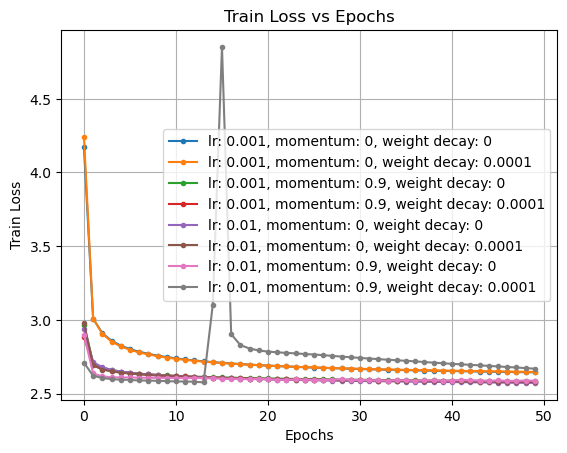

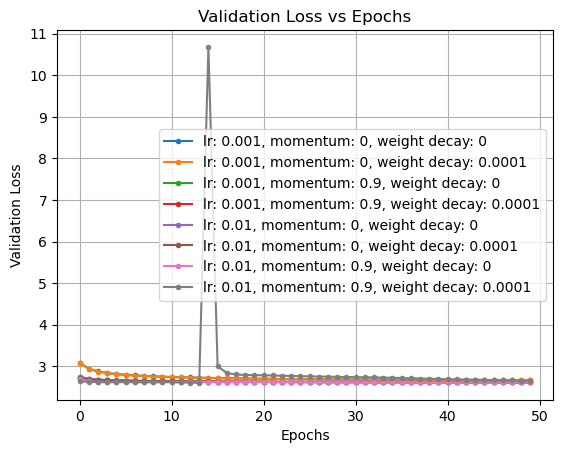

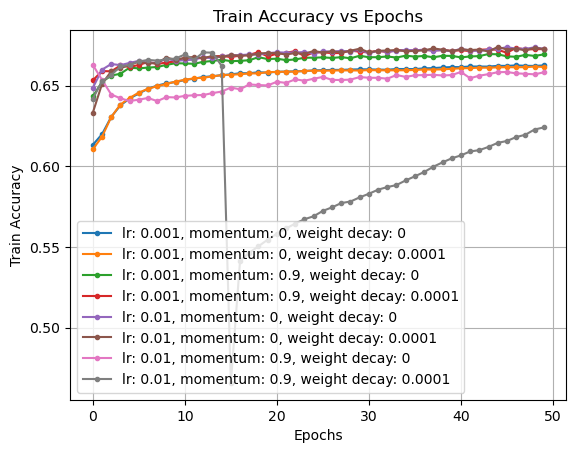

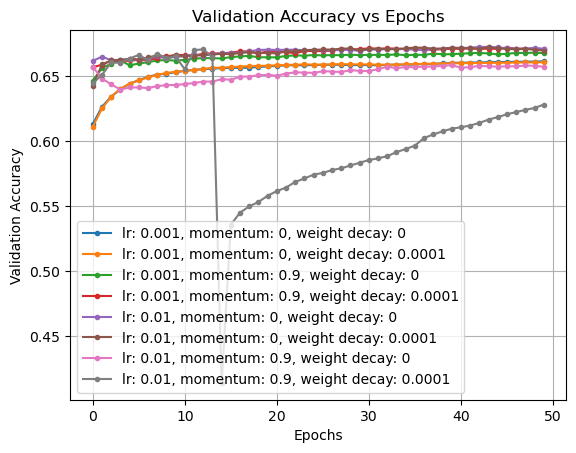

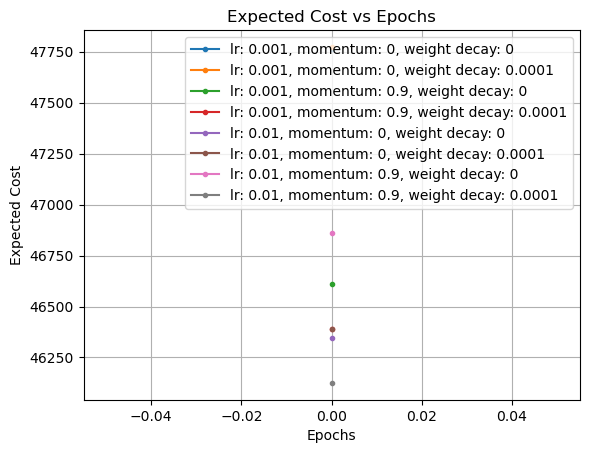

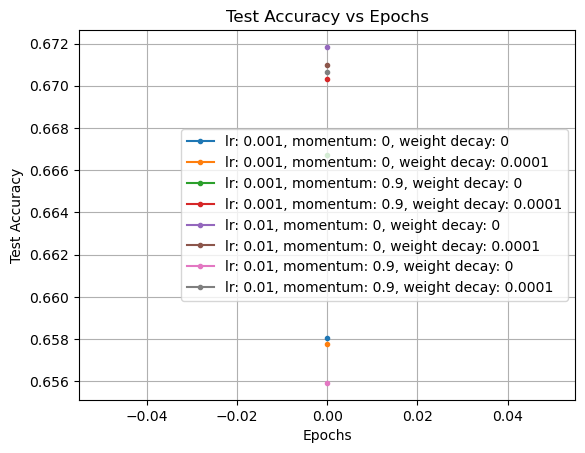

Best expected cost:  46125.11729288101
Best test accuracy:  0.6706553028165039
Best learning rate:  0.001
Best momentum:  0.9
Best weight decay:  0.0001
Best test accuracy:  0.6718406050685782
Best expected cost:  46347.91671538353
Best learning rate:  0.001
Best momentum:  0.9
Best weight decay:  0


In [9]:
# select only first column of y_test
y_test_label = []
for i in range(len(y_test)):
    y_test_label.append(y_test[i][0])

lr_values = [0.001, 0.01]
momentum_values = [0, 0.9]
weight_decay_values = [0, 0.0001]

train_losses_list_cost_lr = []
val_losses_list_cost_lr = []
train_accuracies_list_cost_lr = []
val_accuracies_list_cost_lr = []
expected_costs_list_cost_lr = []
test_accuracy_list_cost_lr = []

for lr in lr_values:
    for momentum in momentum_values:
        for weight_decay in weight_decay_values:
            print("Learning Rate: ", lr)
            print("Momentum: ", momentum)
            print("Weight Decay: ", weight_decay)
            cost_sensitive_log_model = CostSensitiveLogisticRegression(input_dim=X_train.shape[1])
            
            optimizer = torch.optim.SGD(cost_sensitive_log_model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
            
            return_val = cost_sensitive_log_model.train_model(train_loader, val_loader, optimizer=optimizer, num_epochs=50, learning_rate=lr)
            train_losses_cost_sensitive_lr, val_losses_cost_sensitive_lr, train_accuracies_cost_sensitive_lr, val_accuracies_cost_sensitive_lr, best_accuracy_cost_sensitive_lr, best_model_cost_sensitive_lr = return_val
            
            train_losses_list_cost_lr.append(train_losses_cost_sensitive_lr)
            val_losses_list_cost_lr.append(val_losses_cost_sensitive_lr)
            train_accuracies_list_cost_lr.append(train_accuracies_cost_sensitive_lr)
            val_accuracies_list_cost_lr.append(val_accuracies_cost_sensitive_lr)
            expected_costs_list_cost_lr.append(cost_sensitive_log_model.compute_expected_cost(test_loader))
            y_pred = cost_sensitive_log_model(X_test)
            y_pred = y_pred >= 0.5
            y_pred = y_pred.detach().numpy()
            y_pred = y_pred.astype(int)
            y_pred = y_pred.tolist()
            test_accuracy_list_cost_lr.append(accuracy_score(y_test_label, y_pred))


# plot train and validation loss for each hyperparameter combination
print(len(train_losses_list_cost_lr))
# plt.figure(figsize=(20, 10))
plt.figure()
plt.grid()
for i in range(len(lr_values)):
    for j in range(len(momentum_values)):
        for k in range(len(weight_decay_values)):
            print(i*4 + j*2 + k, i, j, k)
            plt.plot(train_losses_list_cost_lr[i*4 + j*2 + k], marker='.' ,label="lr: " + str(lr_values[i]) + ", momentum: " + str(momentum_values[j]) + ", weight decay: " + str(weight_decay_values[k]))
plt.legend()
plt.title("Train Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Train Loss")
plt.show()

plt.figure()
plt.grid()
for i in range(len(lr_values)):
    for j in range(len(momentum_values)):
        for k in range(len(weight_decay_values)):
            plt.plot(val_losses_list_cost_lr[i*4 + j*2 + k], marker='.' , label="lr: " + str(lr_values[i]) + ", momentum: " + str(momentum_values[j]) + ", weight decay: " + str(weight_decay_values[k]))
plt.legend()
plt.title("Validation Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.show()

# plot train and validation accuracy for each hyperparameter combination
plt.figure()
plt.grid()
for i in range(len(lr_values)):
    for j in range(len(momentum_values)):
        for k in range(len(weight_decay_values)):
            plt.plot(train_accuracies_list_cost_lr[i*4 + j*2 + k], marker='.' , label="lr: " + str(lr_values[i]) + ", momentum: " + str(momentum_values[j]) + ", weight decay: " + str(weight_decay_values[k]))
plt.legend()
plt.title("Train Accuracy vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Train Accuracy")
plt.show()

plt.figure()
plt.grid()
for i in range(len(lr_values)):
    for j in range(len(momentum_values)):
        for k in range(len(weight_decay_values)):
            plt.plot(val_accuracies_list_cost_lr[i*4 + j*2 + k], marker='.' , label="lr: " + str(lr_values[i]) + ", momentum: " + str(momentum_values[j]) + ", weight decay: " + str(weight_decay_values[k]))
plt.legend()
plt.title("Validation Accuracy vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.show()

# plot expected cost for each hyperparameter combination
plt.figure()
plt.grid()
for i in range(len(lr_values)):
    for j in range(len(momentum_values)):
        for k in range(len(weight_decay_values)):
            plt.plot(expected_costs_list_cost_lr[i*4 + j*2 + k], marker='.' , label="lr: " + str(lr_values[i]) + ", momentum: " + str(momentum_values[j]) + ", weight decay: " + str(weight_decay_values[k]))
plt.legend()
plt.title("Expected Cost vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Expected Cost")
plt.show()

# plot test accuracy for each hyperparameter combination
plt.figure()
plt.grid()
for i in range(len(lr_values)):
    for j in range(len(momentum_values)):
        for k in range(len(weight_decay_values)):
            plt.plot(test_accuracy_list_cost_lr[i*4 + j*2 + k], marker='.' , label="lr: " + str(lr_values[i]) + ", momentum: " + str(momentum_values[j]) + ", weight decay: " + str(weight_decay_values[k]))
plt.legend()
plt.title("Test Accuracy vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Test Accuracy")
plt.show()

# Print best expected cost and its accuracy and the model hyperparameters
best_expected_cost = min(expected_costs_list_cost_lr)
best_expected_cost_index = expected_costs_list_cost_lr.index(best_expected_cost)
best_test_accuracy = test_accuracy_list_cost_lr[best_expected_cost_index]
best_lr = lr_values[best_expected_cost_index // 8]
best_momentum = momentum_values[(best_expected_cost_index % 8) // 4]
best_weight_decay = weight_decay_values[(best_expected_cost_index % 4) // 2]
print("Best expected cost: ", best_expected_cost)
print("Best test accuracy: ", best_test_accuracy)
print("Best learning rate: ", best_lr)
print("Best momentum: ", best_momentum)
print("Best weight decay: ", best_weight_decay)

# Print best accuracy and its expected cost and the model hyperparameters
best_test_accuracy = max(test_accuracy_list_cost_lr)
best_test_accuracy_index = test_accuracy_list_cost_lr.index(best_test_accuracy)
best_expected_cost = expected_costs_list_cost_lr[best_test_accuracy_index]
best_lr = lr_values[best_test_accuracy_index // 8]
best_momentum = momentum_values[(best_test_accuracy_index % 8) // 4]
best_weight_decay = weight_decay_values[(best_test_accuracy_index % 4) // 2]
print("Best test accuracy: ", best_test_accuracy)
print("Best expected cost: ", best_expected_cost)
print("Best learning rate: ", best_lr)
print("Best momentum: ", best_momentum)
print("Best weight decay: ", best_weight_decay)



In [1]:
plt.figure()
plt.grid()
for i in range(len(lr_values)):
    for j in range(len(momentum_values)):
        for k in range(len(weight_decay_values)):
            print(i*4 + j*2 + k, i, j, k)
            plt.plot(train_losses_list_cost_lr[i*4 + j*2 + k], marker='.' ,label="lr: " + str(lr_values[i]) + ", momentum: " + str(momentum_values[j]) + ", weight decay: " + str(weight_decay_values[k]))
plt.legend()
plt.title("Train Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Train Loss")
plt.show()

plt.figure()
plt.grid()
for i in range(len(lr_values)):
    for j in range(len(momentum_values)):
        for k in range(len(weight_decay_values)):
            plt.plot(val_losses_list_cost_lr[i*4 + j*2 + k], marker='.' , label="lr: " + str(lr_values[i]) + ", momentum: " + str(momentum_values[j]) + ", weight decay: " + str(weight_decay_values[k]))
plt.legend()
plt.title("Validation Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.show()

# plot train and validation accuracy for each hyperparameter combination
plt.figure()
plt.grid()
for i in range(len(lr_values)):
    for j in range(len(momentum_values)):
        for k in range(len(weight_decay_values)):
            plt.plot(train_accuracies_list_cost_lr[i*4 + j*2 + k], marker='.' , label="lr: " + str(lr_values[i]) + ", momentum: " + str(momentum_values[j]) + ", weight decay: " + str(weight_decay_values[k]))
plt.legend()
plt.title("Train Accuracy vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Train Accuracy")
plt.show()

plt.figure()
plt.grid()
for i in range(len(lr_values)):
    for j in range(len(momentum_values)):
        for k in range(len(weight_decay_values)):
            plt.plot(val_accuracies_list_cost_lr[i*4 + j*2 + k], marker='.' , label="lr: " + str(lr_values[i]) + ", momentum: " + str(momentum_values[j]) + ", weight decay: " + str(weight_decay_values[k]))
plt.legend()
plt.title("Validation Accuracy vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.show()

# plot expected cost for each hyperparameter combination
plt.figure()
plt.grid()
for i in range(len(lr_values)):
    for j in range(len(momentum_values)):
        for k in range(len(weight_decay_values)):
            plt.plot(expected_costs_list_cost_lr[i*4 + j*2 + k], marker='.' , label="lr: " + str(lr_values[i]) + ", momentum: " + str(momentum_values[j]) + ", weight decay: " + str(weight_decay_values[k]))
plt.legend()
plt.title("Expected Cost vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Expected Cost")
plt.show()

# plot test accuracy for each hyperparameter combination
plt.figure()
plt.grid()
for i in range(len(lr_values)):
    for j in range(len(momentum_values)):
        for k in range(len(weight_decay_values)):
            plt.plot(test_accuracy_list_cost_lr[i*4 + j*2 + k], marker='.' , label="lr: " + str(lr_values[i]) + ", momentum: " + str(momentum_values[j]) + ", weight decay: " + str(weight_decay_values[k]))
plt.legend()
plt.title("Test Accuracy vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Test Accuracy")
plt.show()


NameError: name 'plt' is not defined

Learning Rate:  0.001
Momentum:  0
Weight Decay:  0
Epoch: 1 	Training Loss: 3.859622 	Training Accuracy: 0.630635 	Validation Loss: 3.092612 	Validation Accuracy: 0.636035
Epoch: 2 	Training Loss: 3.018576 	Training Accuracy: 0.640853 	Validation Loss: 2.951718 	Validation Accuracy: 0.645518
Epoch: 3 	Training Loss: 2.918054 	Training Accuracy: 0.648072 	Validation Loss: 2.886241 	Validation Accuracy: 0.651050
Epoch: 4 	Training Loss: 2.864383 	Training Accuracy: 0.653036 	Validation Loss: 2.846736 	Validation Accuracy: 0.654286
Epoch: 5 	Training Loss: 2.829717 	Training Accuracy: 0.654933 	Validation Loss: 2.819559 	Validation Accuracy: 0.656657
Epoch: 6 	Training Loss: 2.804972 	Training Accuracy: 0.657642 	Validation Loss: 2.799615 	Validation Accuracy: 0.657936
Epoch: 7 	Training Loss: 2.786194 	Training Accuracy: 0.658426 	Validation Loss: 2.784071 	Validation Accuracy: 0.658463
Epoch: 8 	Training Loss: 2.771230 	Training Accuracy: 0.658610 	Validation Loss: 2.771502 	Validation

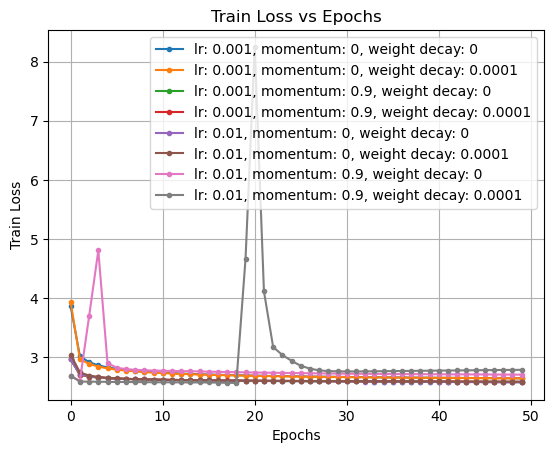

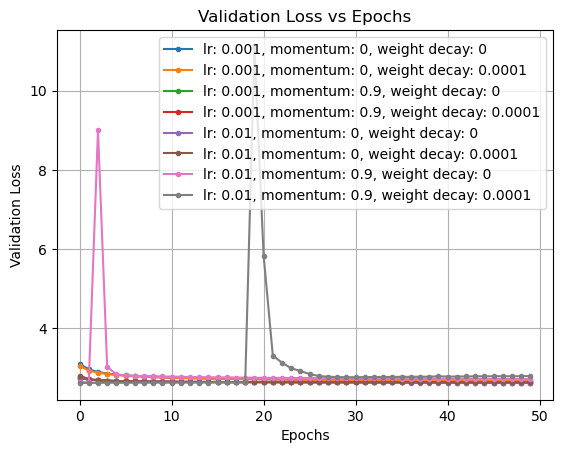

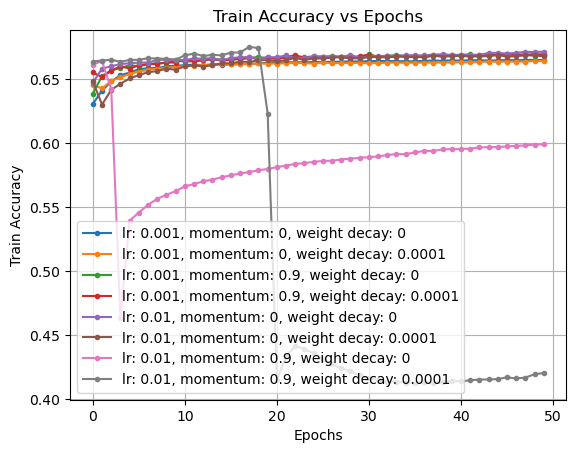

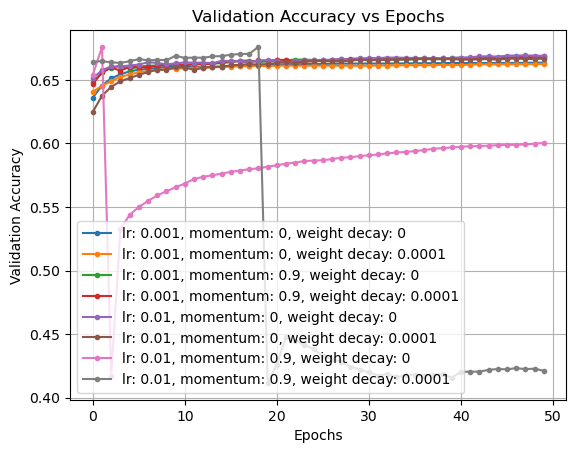

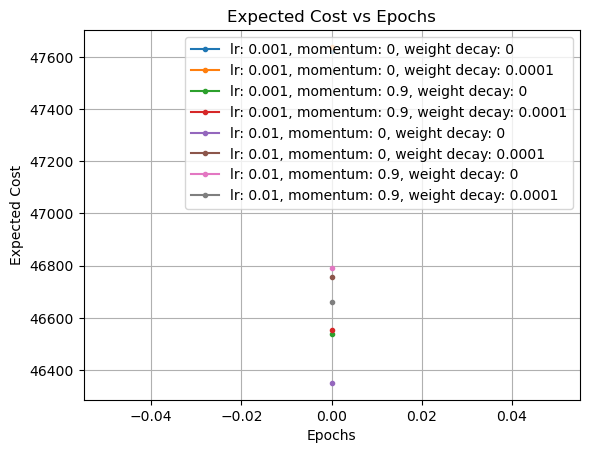

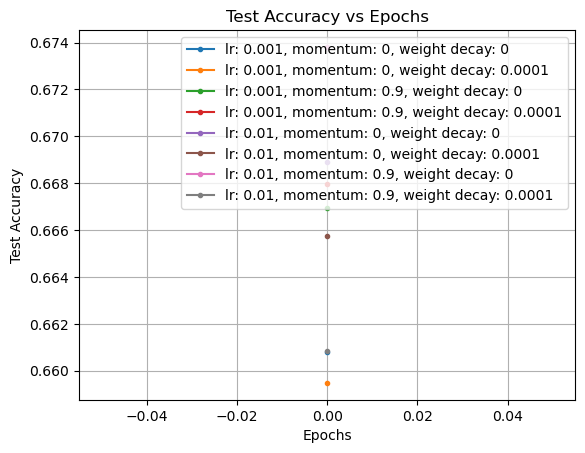

Best expected cost:  46350.26406311989
Best test accuracy:  0.6689055709205848
Best learning rate:  0.001
Best momentum:  0.9
Best weight decay:  0
Best test accuracy:  0.6738161088220354
Best expected cost:  46791.22341680527
Best learning rate:  0.001
Best momentum:  0.9
Best weight decay:  0.0001


In [11]:
# select only first column of y_test
y_test_label = []
for i in range(len(y_test)):
    y_test_label.append(y_test[i][0])

lr_values = [0.001, 0.01]
momentum_values = [0, 0.9]
weight_decay_values = [0, 0.0001]

train_losses_list_cost_lr2 = []
val_losses_list_cost_lr2 = []
train_accuracies_list_cost_lr2 = []
val_accuracies_list_cost_lr2 = []
expected_costs_list_cost_lr2 = []
test_accuracy_list_cost_lr2 = []

for lr in lr_values:
    for momentum in momentum_values:
        for weight_decay in weight_decay_values:
            print("Learning Rate: ", lr)
            print("Momentum: ", momentum)
            print("Weight Decay: ", weight_decay)
            cost_sensitive_log_model = CostSensitiveLogisticRegression(input_dim=X_train.shape[1])
            
            optimizer = torch.optim.SGD(cost_sensitive_log_model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
            
            return_val = cost_sensitive_log_model.train_model2(train_loader, val_loader, optimizer=optimizer, num_epochs=50, learning_rate=lr)
            train_losses_cost_sensitive_lr, val_losses_cost_sensitive_lr, train_accuracies_cost_sensitive_lr, val_accuracies_cost_sensitive_lr, best_accuracy_cost_sensitive_lr, best_model_cost_sensitive_lr = return_val
            
            train_losses_list_cost_lr2.append(train_losses_cost_sensitive_lr)
            val_losses_list_cost_lr2.append(val_losses_cost_sensitive_lr)
            train_accuracies_list_cost_lr2.append(train_accuracies_cost_sensitive_lr)
            val_accuracies_list_cost_lr2.append(val_accuracies_cost_sensitive_lr)
            expected_costs_list_cost_lr2.append(cost_sensitive_log_model.compute_expected_cost(test_loader))
            y_pred = cost_sensitive_log_model(X_test)
            y_pred = y_pred >= 0.5
            y_pred = y_pred.detach().numpy()
            y_pred = y_pred.astype(int)
            y_pred = y_pred.tolist()
            test_accuracy_list_cost_lr2.append(accuracy_score(y_test_label, y_pred))
            
# plot train and validation loss for each hyperparameter combination
print(len(train_losses_list_cost_lr2))
# plt.figure(figsize=(20, 10))
plt.figure()
plt.grid()
for i in range(len(lr_values)):
    for j in range(len(momentum_values)):
        for k in range(len(weight_decay_values)):
            print(i*4 + j*2 + k, i, j, k)
            plt.plot(train_losses_list_cost_lr2[i*4 + j*2 + k], marker='.' ,label="lr: " + str(lr_values[i]) + ", momentum: " + str(momentum_values[j]) + ", weight decay: " + str(weight_decay_values[k]))
plt.legend()
plt.title("Train Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Train Loss")
plt.show()

plt.figure()
plt.grid()
for i in range(len(lr_values)):
    for j in range(len(momentum_values)):
        for k in range(len(weight_decay_values)):
            plt.plot(val_losses_list_cost_lr2[i*4 + j*2 + k], marker='.' , label="lr: " + str(lr_values[i]) + ", momentum: " + str(momentum_values[j]) + ", weight decay: " + str(weight_decay_values[k]))
plt.legend()
plt.title("Validation Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.show()

# plot train and validation accuracy for each hyperparameter combination
plt.figure()
plt.grid()
for i in range(len(lr_values)):
    for j in range(len(momentum_values)):
        for k in range(len(weight_decay_values)):
            plt.plot(train_accuracies_list_cost_lr2[i*4 + j*2 + k], marker='.' , label="lr: " + str(lr_values[i]) + ", momentum: " + str(momentum_values[j]) + ", weight decay: " + str(weight_decay_values[k]))
plt.legend()
plt.title("Train Accuracy vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Train Accuracy")
plt.show()

plt.figure()
plt.grid()
for i in range(len(lr_values)):
    for j in range(len(momentum_values)):
        for k in range(len(weight_decay_values)):
            plt.plot(val_accuracies_list_cost_lr2[i*4 + j*2 + k], marker='.' , label="lr: " + str(lr_values[i]) + ", momentum: " + str(momentum_values[j]) + ", weight decay: " + str(weight_decay_values[k]))
plt.legend()
plt.title("Validation Accuracy vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.show()

# plot expected cost for each hyperparameter combination
plt.figure()
plt.grid()
for i in range(len(lr_values)):
    for j in range(len(momentum_values)):
        for k in range(len(weight_decay_values)):
            plt.plot(expected_costs_list_cost_lr2[i*4 + j*2 + k], marker='.' , label="lr: " + str(lr_values[i]) + ", momentum: " + str(momentum_values[j]) + ", weight decay: " + str(weight_decay_values[k]))
plt.legend()
plt.title("Expected Cost vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Expected Cost")
plt.show()

# plot test accuracy for each hyperparameter combination
plt.figure()
plt.grid()
for i in range(len(lr_values)):
    for j in range(len(momentum_values)):
        for k in range(len(weight_decay_values)):
            plt.plot(test_accuracy_list_cost_lr2[i*4 + j*2 + k], marker='.' , label="lr: " + str(lr_values[i]) + ", momentum: " + str(momentum_values[j]) + ", weight decay: " + str(weight_decay_values[k]))
plt.legend()
plt.title("Test Accuracy vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Test Accuracy")
plt.show()


# Print best expected cost and its accuracy and the model hyperparameters
best_expected_cost = min(expected_costs_list_cost_lr2)
best_expected_cost_index = expected_costs_list_cost_lr2.index(best_expected_cost)
best_test_accuracy = test_accuracy_list_cost_lr2[best_expected_cost_index]
best_lr = lr_values[best_expected_cost_index // 8]
best_momentum = momentum_values[(best_expected_cost_index % 8) // 4]
best_weight_decay = weight_decay_values[(best_expected_cost_index % 4) // 2]
print("Best expected cost: ", best_expected_cost)
print("Best test accuracy: ", best_test_accuracy)
print("Best learning rate: ", best_lr)
print("Best momentum: ", best_momentum)
print("Best weight decay: ", best_weight_decay)

# Print best accuracy and its expected cost and the model hyperparameters
best_test_accuracy = max(test_accuracy_list_cost_lr2)
best_test_accuracy_index = test_accuracy_list_cost_lr2.index(best_test_accuracy)
best_expected_cost = expected_costs_list_cost_lr2[best_test_accuracy_index]
best_lr = lr_values[best_test_accuracy_index // 8]
best_momentum = momentum_values[(best_test_accuracy_index % 8) // 4]
best_weight_decay = weight_decay_values[(best_test_accuracy_index % 4) // 2]
print("Best test accuracy: ", best_test_accuracy)
print("Best expected cost: ", best_expected_cost)
print("Best learning rate: ", best_lr)
print("Best momentum: ", best_momentum)
print("Best weight decay: ", best_weight_decay)



8
0 0 0 0
1 0 0 1
2 0 1 0
3 0 1 1
4 1 0 0
5 1 0 1
6 1 1 0
7 1 1 1


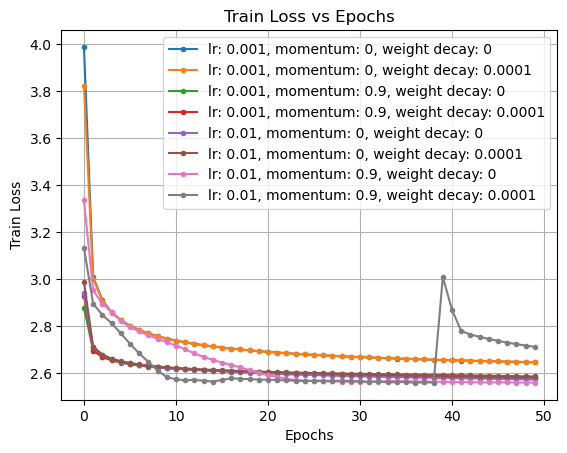

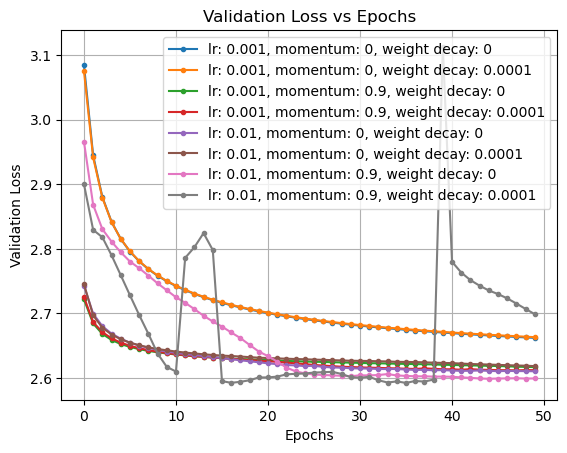

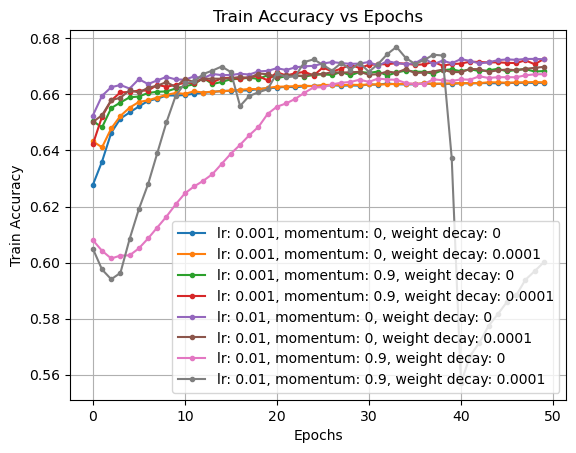

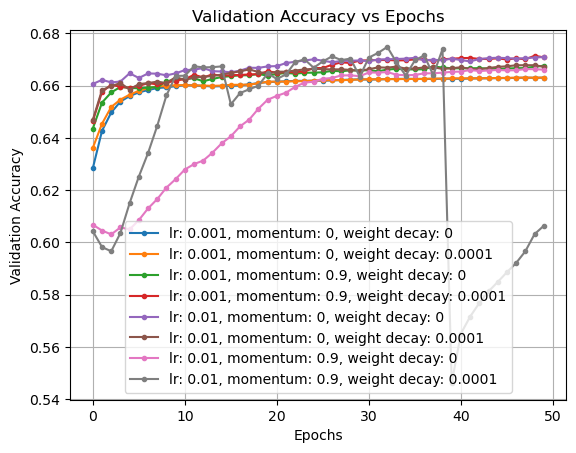

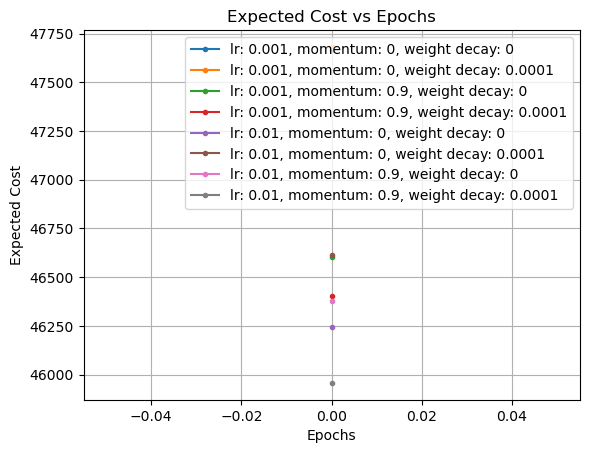

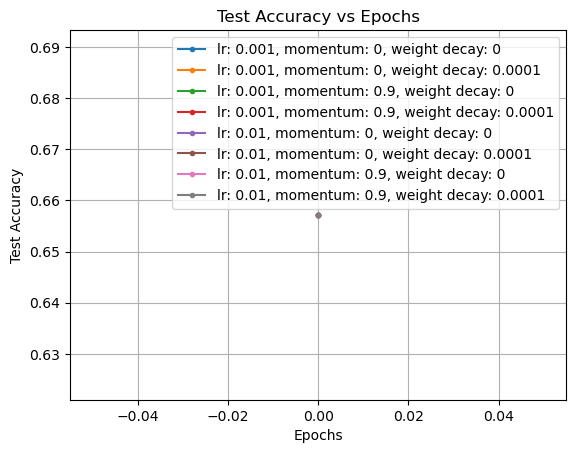

In [30]:
# plot train and validation loss for each hyperparameter combination
print(len(train_losses_list))
# plt.figure(figsize=(20, 10))
plt.figure()
plt.grid()
for i in range(len(lr_values)):
    for j in range(len(momentum_values)):
        for k in range(len(weight_decay_values)):
            print(i*4 + j*2 + k, i, j, k)
            plt.plot(train_losses_list[i*4 + j*2 + k], marker='.' ,label="lr: " + str(lr_values[i]) + ", momentum: " + str(momentum_values[j]) + ", weight decay: " + str(weight_decay_values[k]))
plt.legend()
plt.title("Train Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Train Loss")
plt.show()

plt.figure()
plt.grid()
for i in range(len(lr_values)):
    for j in range(len(momentum_values)):
        for k in range(len(weight_decay_values)):
            plt.plot(val_losses_list[i*4 + j*2 + k], marker='.' , label="lr: " + str(lr_values[i]) + ", momentum: " + str(momentum_values[j]) + ", weight decay: " + str(weight_decay_values[k]))
plt.legend()
plt.title("Validation Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.show()

# plot train and validation accuracy for each hyperparameter combination
plt.figure()
plt.grid()
for i in range(len(lr_values)):
    for j in range(len(momentum_values)):
        for k in range(len(weight_decay_values)):
            plt.plot(train_accuracies_list[i*4 + j*2 + k], marker='.' , label="lr: " + str(lr_values[i]) + ", momentum: " + str(momentum_values[j]) + ", weight decay: " + str(weight_decay_values[k]))
plt.legend()
plt.title("Train Accuracy vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Train Accuracy")
plt.show()

plt.figure()
plt.grid()
for i in range(len(lr_values)):
    for j in range(len(momentum_values)):
        for k in range(len(weight_decay_values)):
            plt.plot(val_accuracies_list[i*4 + j*2 + k], marker='.' , label="lr: " + str(lr_values[i]) + ", momentum: " + str(momentum_values[j]) + ", weight decay: " + str(weight_decay_values[k]))
plt.legend()
plt.title("Validation Accuracy vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.show()

# plot expected cost for each hyperparameter combination
plt.figure()
plt.grid()
for i in range(len(lr_values)):
    for j in range(len(momentum_values)):
        for k in range(len(weight_decay_values)):
            plt.plot(expected_costs_list[i*4 + j*2 + k], marker='.' , label="lr: " + str(lr_values[i]) + ", momentum: " + str(momentum_values[j]) + ", weight decay: " + str(weight_decay_values[k]))
plt.legend()
plt.title("Expected Cost vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Expected Cost")
plt.show()

# plot test accuracy for each hyperparameter combination
plt.figure()
plt.grid()
for i in range(len(lr_values)):
    for j in range(len(momentum_values)):
        for k in range(len(weight_decay_values)):
            plt.plot(test_accuracy_list[i*4 + j*2 + k], marker='.' , label="lr: " + str(lr_values[i]) + ", momentum: " + str(momentum_values[j]) + ", weight decay: " + str(weight_decay_values[k]))
plt.legend()
plt.title("Test Accuracy vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Test Accuracy")
plt.show()



# cost_sensitive_log_model = CostSensitiveLogisticRegression(input_dim=X_train.shape[1])

# optimizer = torch.optim.SGD(cost_sensitive_log_model.parameters(), lr=0.001)

# return_val = cost_sensitive_log_model.train_model(train_loader, val_loader, optimizer=optimizer, num_epochs=10, learning_rate=0.001)

# train_losses_cost_sensitive_lr, val_losses_cost_sensitive_lr, train_accuracies_cost_sensitive_lr, val_accuracies_cost_sensitive_lr, best_accuracy_cost_sensitive_lr, best_model_cost_sensitive_lr = return_val


# print("Cost of Cost Sensitive Logistic Regression Model: ", cost_sensitive_log_model.compute_expected_cost(test_loader))

# y_pred = cost_sensitive_log_model(X_test)
# y_pred = y_pred >= 0.5
# y_pred = y_pred.detach().numpy()
# y_pred = y_pred.astype(int)

# # select only first column of y_test
# y_test_label = []
# for i in range(len(y_test)):
#     y_test_label.append(y_test[i][0])

# # convert y_pred and y_test into list
# y_pred = y_pred.tolist()
# # y_test = y_test.tolist()
# # print precision, recall, f1 score
# print(classification_report(y_test_label, y_pred))

# # print accuracy
# print("Accuracy: ", accuracy_score(y_test_label, y_pred))

In [12]:
class LogisticRegression(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegression, self).__init__()
        # Defining the number of input features
        self.input_dim = input_dim
        # Defining the number of output features
        self.output_dim = 1
        self.model = nn.Sequential(
            nn.Linear(input_dim, 1),
            nn.Sigmoid()
        )
        self.loss_critetion = nn.BCELoss()
        
    def forward(self, x):
        out = self.model(x)
        return out
    
    def compute_loss(self, y_pred, y_true, false_negative_cost):
        epsilon = 1e-7
        true_positive_cost = 4.0
        false_positive_cost = 4.0
        true_negative_cost = 0
        # print("False Negative Cost: ",false_negative_cost.reshape(-1,1).shape)
        
        # print("Y_pred Shape: ",y_pred.shape)
        # print("Y_true Shape: ",y_true.shape)

        # Compute the losses for true positives, false positives, true negatives, and false negatives
        # tp_loss = y_true * torch.log(y_pred + epsilon) * true_positive_cost
        # fp_loss = y_true * torch.log(1 - y_pred + epsilon) * false_positive_cost
        # tn_loss = (1 - y_true) * torch.log(1 - y_pred + epsilon) * true_negative_cost
        # fn_loss = (1 - y_true) * torch.log(y_pred + epsilon) * false_negative_cost
        
        tp_loss = y_true * y_pred * true_positive_cost
        fp_loss = (1 - y_true) * y_pred * false_positive_cost
        fn_loss = (y_true * (1 - y_pred)) * false_negative_cost.reshape(-1,1)
        # tn_loss = (1 - y_true) * (1 - y_pred) * true_negative_cost
        tn_loss = torch.multiply((1 - y_true), (1 - y_pred)) * true_negative_cost
        # print((1-y_true).shape)
        # print((1-y_pred).shape)

        # Compute the total loss
        # total_loss = y_true * (y_pred * true_positive_cost + (1 - y_pred) * false_negative_cost) + (1 - y_true) * (y_pred * false_positive_cost + (1 - y_pred) * true_negative_cost)

        # total_loss = total_loss.mean()
        total_loss = tp_loss + fp_loss + tn_loss + fn_loss
        # print(tp_loss.shape, fp_loss.shape, tn_loss.shape, fn_loss.shape)
        # print("Loss Shape: ",total_loss.shape)
        total_loss = total_loss.mean()

        return total_loss
    
    def compute_expected_cost(self, test_loader):
        # compute the expected cost for the test data
        total_cost = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = self(data)
            false_neg_cost = target[:, 1]
            target = target[:, 0].view(-1, 1)
            loss = self.compute_loss(output, target, false_neg_cost)
            total_cost += loss.item() * data.size(0)
        return total_cost
    
    def train_model(self, train_loader, test_loader, optimizer, num_epochs, learning_rate):
        # Define the loss function and the optimizer
        criterion = self.loss_critetion
        # optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        
        self.train()

        # Lists to keep track of progress
        train_losses = []
        test_losses = []
        test_accuracies = []
        train_accuracies = []
        best_accuracy = 0
        best_model = None

        # Number of epochs
        n_epochs = num_epochs

        for epoch in range(n_epochs):
            # Monitor training loss
            train_loss = 0.0
            total_classified = 0
            correct_classified = 0
            self.train()
            for batch_idx, (data, target) in enumerate(train_loader):
                # print('Batch: ', batch_idx)
                # print(data.shape)
                # print(target.shape)
                target = target[:, 0].view(-1, 1)
                # Clear the gradients of all optimized variables
                optimizer.zero_grad()
                # Forward pass: compute predicted outputs by passing inputs to the model
                output = self(data)
                # Calculate the batch loss
                loss = criterion(output, target)
                # Backward pass: compute gradient of the loss with respect to model parameters
                loss.backward()
                # Perform a single optimization step (parameter update)
                optimizer.step()
                # Update running training loss
                train_loss += loss.item() * data.size(0)
                # Calculate the number of correct classifications
                pred = output >= 0.5
                correct_classified += (pred == target).sum().item()
                total_classified += len(target)
        
            # Calculate average loss over an epoch
            train_loss = train_loss / len(train_loader.dataset)
    
            # Calculate training accuracy
            train_accuracy = correct_classified / total_classified
        
            # Append to the training loss and accuracy lists
            train_accuracies.append(train_accuracy)
            train_losses.append(train_loss)
        
            # Test the model for validation
            test_loss = 0.0
            total_classified = 0
            correct_classified = 0
            self.eval()
            for batch_idx, (data, target) in enumerate(test_loader):
                # Forward pass: compute predicted outputs by passing inputs to the model
                output = self(data)
                target = target[:, 0].view(-1, 1)
                # Calculate the batch loss
                loss = criterion(output, target)
                # Update running validation loss 
                test_loss += loss.item() * data.size(0)
                # Calculate the number of correct classifications
                pred = output >= 0.5
                correct_classified += (pred == target).sum().item()
                total_classified += len(target)
        
            # Calculate average loss over an epoch
            test_loss = test_loss / len(test_loader.dataset)
        
            # Calculate validation accuracy
            test_accuracy = correct_classified / total_classified
        
            # Append to the validation loss and accuracy lists
            test_accuracies.append(test_accuracy)
            test_losses.append(test_loss)
        
            # print both test and train loss and accuracy
            print('Epoch: {} \tTraining Loss: {:.6f} \tTraining Accuracy: {:.6f} \tValidation Loss: {:.6f} \tValidation Accuracy: {:.6f}'.format(epoch+1, train_loss, train_accuracy, test_loss, test_accuracy))
            
            if test_accuracy > best_accuracy:
                best_accuracy = test_accuracy
                # best_model = self.state_dict()
                # torch.save(best_model, 'best_model.pt')
                torch.save(self.state_dict(), 'best_model.pt')
            
        # print('Best Accuracy: ', best_accuracy)
        # Load the best model
        self.load_state_dict(torch.load('best_model.pt'))
        return train_losses, test_losses, train_accuracies, test_accuracies, best_accuracy, best_model
    
    def train_model2(self, train_loader, test_loader, optimizer, num_epochs, learning_rate):
        # Define the loss function and the optimizer
        criterion = self.loss_critetion
        # optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        
        self.train()

        # Lists to keep track of progress
        train_losses = []
        test_losses = []
        test_accuracies = []
        train_accuracies = []
        best_expected_cost = float('inf')
        best_model = None

        # Number of epochs
        n_epochs = num_epochs

        for epoch in range(n_epochs):
            # Monitor training loss
            train_loss = 0.0
            total_classified = 0
            correct_classified = 0
            self.train()
            for batch_idx, (data, target) in enumerate(train_loader):
                # print('Batch: ', batch_idx)
                # print(data.shape)
                # print(target.shape)
                target = target[:, 0].view(-1, 1)
                # Clear the gradients of all optimized variables
                optimizer.zero_grad()
                # Forward pass: compute predicted outputs by passing inputs to the model
                output = self(data)
                # Calculate the batch loss
                loss = criterion(output, target)
                # Backward pass: compute gradient of the loss with respect to model parameters
                loss.backward()
                # Perform a single optimization step (parameter update)
                optimizer.step()
                # Update running training loss
                train_loss += loss.item() * data.size(0)
                # Calculate the number of correct classifications
                pred = output >= 0.5
                correct_classified += (pred == target).sum().item()
                total_classified += len(target)
        
            # Calculate average loss over an epoch
            train_loss = train_loss / len(train_loader.dataset)
    
            # Calculate training accuracy
            train_accuracy = correct_classified / total_classified
        
            # Append to the training loss and accuracy lists
            train_accuracies.append(train_accuracy)
            train_losses.append(train_loss)
        
            # Test the model for validation
            test_loss = 0.0
            total_classified = 0
            correct_classified = 0
            self.eval()
            for batch_idx, (data, target) in enumerate(test_loader):
                # Forward pass: compute predicted outputs by passing inputs to the model
                output = self(data)
                target = target[:, 0].view(-1, 1)
                # Calculate the batch loss
                loss = criterion(output, target)
                # Update running validation loss 
                test_loss += loss.item() * data.size(0)
                # Calculate the number of correct classifications
                pred = output >= 0.5
                correct_classified += (pred == target).sum().item()
                total_classified += len(target)
        
            # Calculate average loss over an epoch
            test_loss = test_loss / len(test_loader.dataset)
        
            # Calculate validation accuracy
            test_accuracy = correct_classified / total_classified
            test_expected_cost = self.compute_expected_cost(test_loader)
        
            # Append to the validation loss and accuracy lists
            test_accuracies.append(test_accuracy)
            test_losses.append(test_loss)
        
            # print both test and train loss and accuracy
            print('Epoch: {} \tTraining Loss: {:.6f} \tTraining Accuracy: {:.6f} \tValidation Loss: {:.6f} \tValidation Accuracy: {:.6f}'.format(epoch+1, train_loss, train_accuracy, test_loss, test_accuracy))
            
            if test_expected_cost < best_expected_cost:
                best_expected_cost = test_expected_cost
                # best_model = self.state_dict()
                # torch.save(best_model, 'best_model.pt')
                torch.save(self.state_dict(), 'best_model.pt')
            
        # print('Best Accuracy: ', best_accuracy)
        # Load the best model
        self.load_state_dict(torch.load('best_model.pt'))
        return train_losses, test_losses, train_accuracies, test_accuracies, best_expected_cost, best_model
    
    def predict(self, test_loader):
        self.eval()
        preds = []
        for batch_idx, (data, target) in enumerate(test_loader):
            output = self(data)
            pred = output >= 0.5
            preds.append(pred)
        return preds
    

Learning Rate:  0.001
Momentum:  0
Weight Decay:  0
Epoch: 1 	Training Loss: 0.536083 	Training Accuracy: 0.802477 	Validation Loss: 0.431523 	Validation Accuracy: 0.861293
Epoch: 2 	Training Loss: 0.388662 	Training Accuracy: 0.865228 	Validation Loss: 0.363801 	Validation Accuracy: 0.862648
Epoch: 3 	Training Loss: 0.346110 	Training Accuracy: 0.866205 	Validation Loss: 0.338467 	Validation Accuracy: 0.863701
Epoch: 4 	Training Loss: 0.328338 	Training Accuracy: 0.866351 	Validation Loss: 0.326737 	Validation Accuracy: 0.863965
Epoch: 5 	Training Loss: 0.319594 	Training Accuracy: 0.866447 	Validation Loss: 0.320611 	Validation Accuracy: 0.864191
Epoch: 6 	Training Loss: 0.314856 	Training Accuracy: 0.866467 	Validation Loss: 0.317167 	Validation Accuracy: 0.864078
Epoch: 7 	Training Loss: 0.312104 	Training Accuracy: 0.866573 	Validation Loss: 0.315127 	Validation Accuracy: 0.863965
Epoch: 8 	Training Loss: 0.310429 	Training Accuracy: 0.866534 	Validation Loss: 0.313869 	Validation

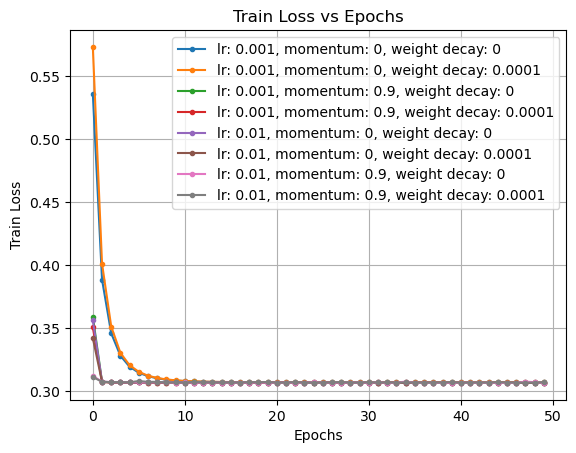

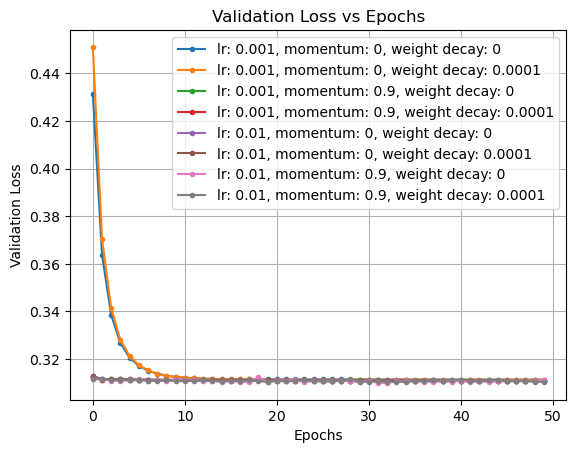

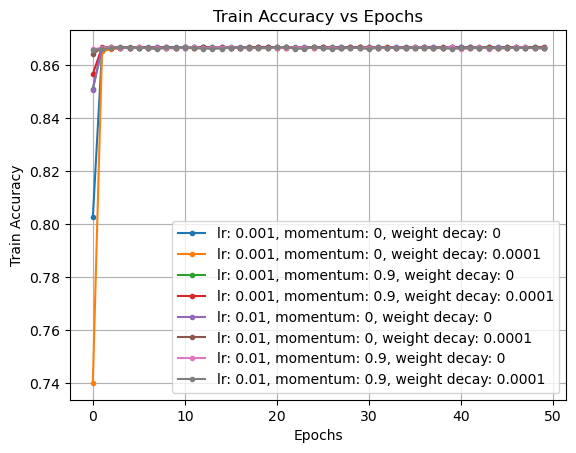

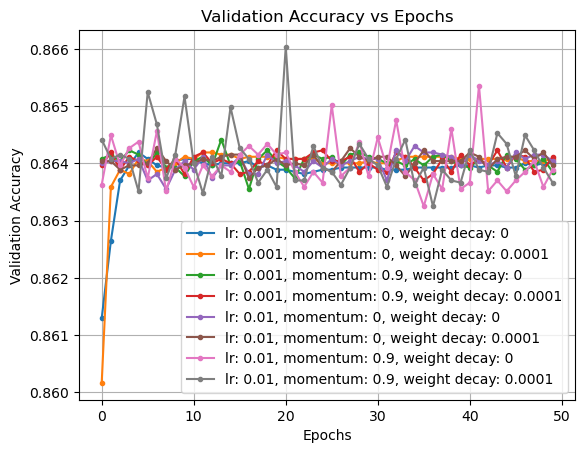

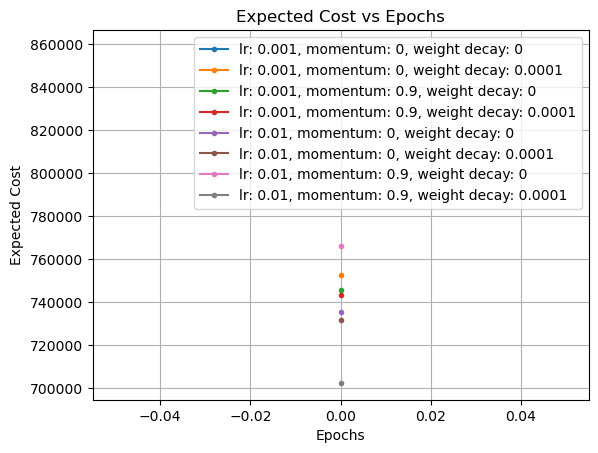

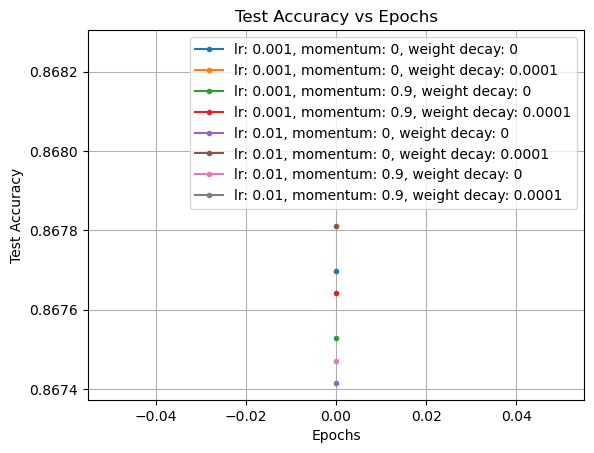

Best expected cost:  702493.099834919
Best test accuracy:  0.8682621211266016
Best learning rate:  0.001
Best momentum:  0.9
Best weight decay:  0.0001
Best test accuracy:  0.8682621211266016
Best expected cost:  702493.099834919
Best learning rate:  0.001
Best momentum:  0.9
Best weight decay:  0.0001


In [13]:
# select only first column of y_test
y_test_label = []
for i in range(len(y_test)):
    y_test_label.append(y_test[i][0])

lr_values = [0.001, 0.01]
momentum_values = [0, 0.9]
weight_decay_values = [0, 0.0001]

train_losses_list_lr = []
val_losses_list_lr = []
train_accuracies_list_lr = []
val_accuracies_list_lr = []
expected_costs_list_lr = []
test_accuracy_list_lr = []

for lr in lr_values:
    for momentum in momentum_values:
        for weight_decay in weight_decay_values:
            print("Learning Rate: ", lr)
            print("Momentum: ", momentum)
            print("Weight Decay: ", weight_decay)
            cost_sensitive_log_model = LogisticRegression(input_dim=X_train.shape[1])
            
            optimizer = torch.optim.SGD(cost_sensitive_log_model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
            
            return_val = cost_sensitive_log_model.train_model(train_loader, val_loader, optimizer=optimizer, num_epochs=50, learning_rate=lr)
            train_losses_cost_sensitive_lr, val_losses_cost_sensitive_lr, train_accuracies_cost_sensitive_lr, val_accuracies_cost_sensitive_lr, best_accuracy_cost_sensitive_lr, best_model_cost_sensitive_lr = return_val
            
            train_losses_list_lr.append(train_losses_cost_sensitive_lr)
            val_losses_list_lr.append(val_losses_cost_sensitive_lr)
            train_accuracies_list_lr.append(train_accuracies_cost_sensitive_lr)
            val_accuracies_list_lr.append(val_accuracies_cost_sensitive_lr)
            expected_costs_list_lr.append(cost_sensitive_log_model.compute_expected_cost(test_loader))
            y_pred = cost_sensitive_log_model(X_test)
            y_pred = y_pred >= 0.5
            y_pred = y_pred.detach().numpy()
            y_pred = y_pred.astype(int)
            y_pred = y_pred.tolist()
            test_accuracy_list_lr.append(accuracy_score(y_test_label, y_pred))
            
# plot train and validation loss for each hyperparameter combination
print(len(train_losses_list_lr))
# plt.figure(figsize=(20, 10))
plt.figure()
plt.grid()
for i in range(len(lr_values)):
    for j in range(len(momentum_values)):
        for k in range(len(weight_decay_values)):
            print(i*4 + j*2 + k, i, j, k)
            plt.plot(train_losses_list_lr[i*4 + j*2 + k], marker='.' ,label="lr: " + str(lr_values[i]) + ", momentum: " + str(momentum_values[j]) + ", weight decay: " + str(weight_decay_values[k]))
plt.legend()
plt.title("Train Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Train Loss")
plt.show()

plt.figure()
plt.grid()
for i in range(len(lr_values)):
    for j in range(len(momentum_values)):
        for k in range(len(weight_decay_values)):
            plt.plot(val_losses_list_lr[i*4 + j*2 + k], marker='.' , label="lr: " + str(lr_values[i]) + ", momentum: " + str(momentum_values[j]) + ", weight decay: " + str(weight_decay_values[k]))
plt.legend()
plt.title("Validation Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.show()

# plot train and validation accuracy for each hyperparameter combination
plt.figure()
plt.grid()
for i in range(len(lr_values)):
    for j in range(len(momentum_values)):
        for k in range(len(weight_decay_values)):
            plt.plot(train_accuracies_list_lr[i*4 + j*2 + k], marker='.' , label="lr: " + str(lr_values[i]) + ", momentum: " + str(momentum_values[j]) + ", weight decay: " + str(weight_decay_values[k]))
plt.legend()
plt.title("Train Accuracy vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Train Accuracy")
plt.show()

plt.figure()
plt.grid()
for i in range(len(lr_values)):
    for j in range(len(momentum_values)):
        for k in range(len(weight_decay_values)):
            plt.plot(val_accuracies_list_lr[i*4 + j*2 + k], marker='.' , label="lr: " + str(lr_values[i]) + ", momentum: " + str(momentum_values[j]) + ", weight decay: " + str(weight_decay_values[k]))
plt.legend()
plt.title("Validation Accuracy vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.show()

# plot expected cost for each hyperparameter combination
plt.figure()
plt.grid()
for i in range(len(lr_values)):
    for j in range(len(momentum_values)):
        for k in range(len(weight_decay_values)):
            plt.plot(expected_costs_list_lr[i*4 + j*2 + k], marker='.' , label="lr: " + str(lr_values[i]) + ", momentum: " + str(momentum_values[j]) + ", weight decay: " + str(weight_decay_values[k]))
plt.legend()
plt.title("Expected Cost vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Expected Cost")
plt.show()

# plot test accuracy for each hyperparameter combination
plt.figure()
plt.grid()
for i in range(len(lr_values)):
    for j in range(len(momentum_values)):
        for k in range(len(weight_decay_values)):
            plt.plot(test_accuracy_list_lr[i*4 + j*2 + k], marker='.' , label="lr: " + str(lr_values[i]) + ", momentum: " + str(momentum_values[j]) + ", weight decay: " + str(weight_decay_values[k]))
plt.legend()
plt.title("Test Accuracy vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Test Accuracy")
plt.show()

# Print best expected cost and its accuracy and the model hyperparameters
best_expected_cost = min(expected_costs_list_lr)
best_expected_cost_index = expected_costs_list_lr.index(best_expected_cost)
best_test_accuracy = test_accuracy_list_lr[best_expected_cost_index]
best_lr = lr_values[best_expected_cost_index // 8]
best_momentum = momentum_values[(best_expected_cost_index % 8) // 4]
best_weight_decay = weight_decay_values[(best_expected_cost_index % 4) // 2]
print("Best expected cost: ", best_expected_cost)
print("Best test accuracy: ", best_test_accuracy)
print("Best learning rate: ", best_lr)
print("Best momentum: ", best_momentum)
print("Best weight decay: ", best_weight_decay)

# Print best accuracy and its expected cost and the model hyperparameters
best_test_accuracy = max(test_accuracy_list_lr)
best_test_accuracy_index = test_accuracy_list_lr.index(best_test_accuracy)
best_expected_cost = expected_costs_list_lr[best_test_accuracy_index]
best_lr = lr_values[best_test_accuracy_index // 8]
best_momentum = momentum_values[(best_test_accuracy_index % 8) // 4]
best_weight_decay = weight_decay_values[(best_test_accuracy_index % 4) // 2]
print("Best test accuracy: ", best_test_accuracy)
print("Best expected cost: ", best_expected_cost)
print("Best learning rate: ", best_lr)
print("Best momentum: ", best_momentum)
print("Best weight decay: ", best_weight_decay)



Learning Rate:  0.001
Momentum:  0
Weight Decay:  0
Epoch: 1 	Training Loss: 0.483173 	Training Accuracy: 0.851449 	Validation Loss: 0.408511 	Validation Accuracy: 0.863363
Epoch: 2 	Training Loss: 0.375652 	Training Accuracy: 0.865857 	Validation Loss: 0.355826 	Validation Accuracy: 0.864492
Epoch: 3 	Training Loss: 0.341293 	Training Accuracy: 0.866205 	Validation Loss: 0.334943 	Validation Accuracy: 0.864341
Epoch: 4 	Training Loss: 0.326226 	Training Accuracy: 0.866283 	Validation Loss: 0.324924 	Validation Accuracy: 0.864191
Epoch: 5 	Training Loss: 0.318522 	Training Accuracy: 0.866322 	Validation Loss: 0.319556 	Validation Accuracy: 0.864341
Epoch: 6 	Training Loss: 0.314214 	Training Accuracy: 0.866263 	Validation Loss: 0.316471 	Validation Accuracy: 0.864266
Epoch: 7 	Training Loss: 0.311675 	Training Accuracy: 0.866351 	Validation Loss: 0.314629 	Validation Accuracy: 0.864191
Epoch: 8 	Training Loss: 0.310121 	Training Accuracy: 0.866457 	Validation Loss: 0.313490 	Validation

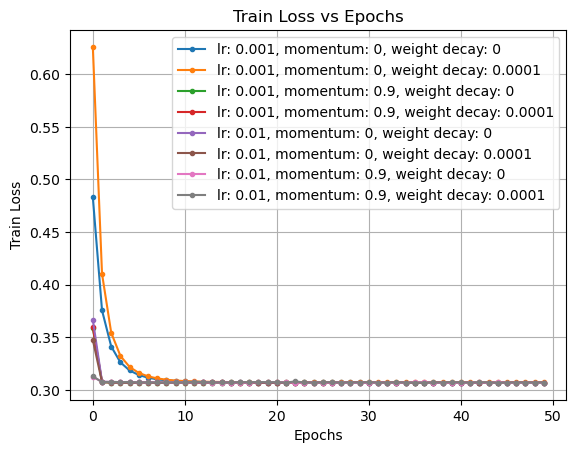

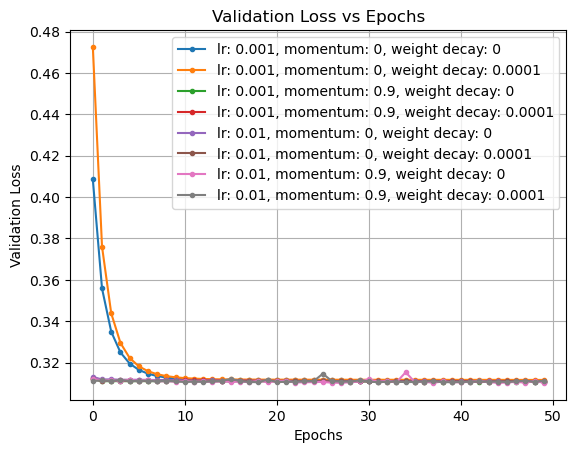

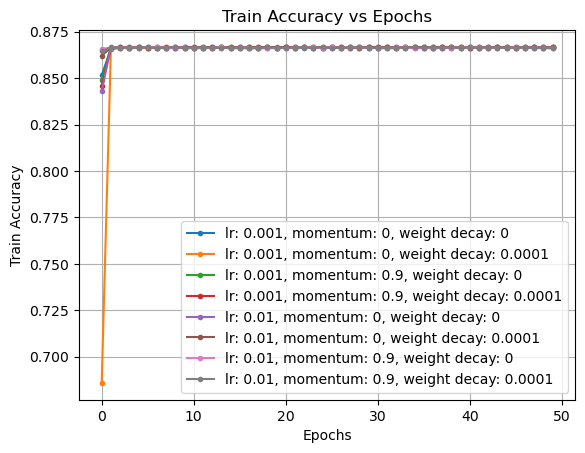

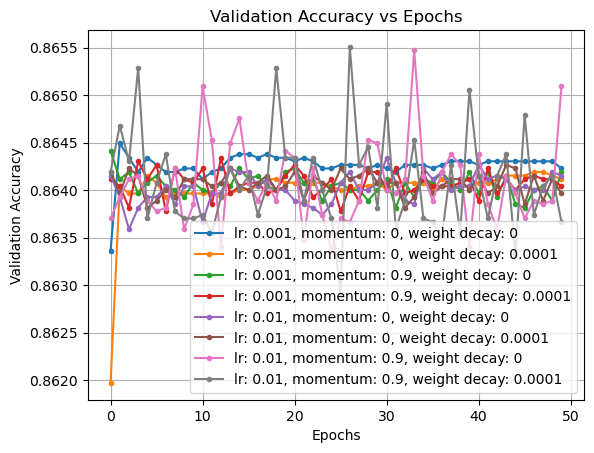

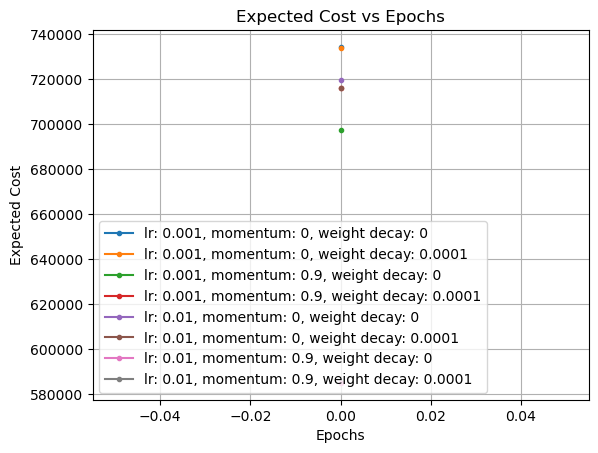

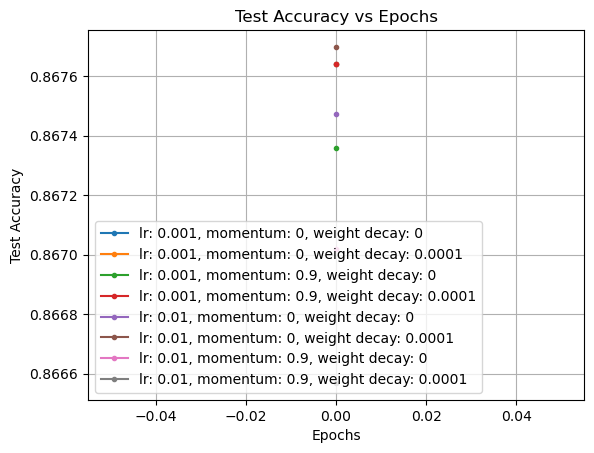

Best expected cost:  585138.685002327
Best test accuracy:  0.8670203759101428
Best learning rate:  0.001
Best momentum:  0.9
Best weight decay:  0.0001
Best test accuracy:  0.8676976914827567
Best expected cost:  716188.8934950829
Best learning rate:  0.001
Best momentum:  0.9
Best weight decay:  0


In [14]:
# select only first column of y_test
y_test_label = []
for i in range(len(y_test)):
    y_test_label.append(y_test[i][0])

lr_values = [0.001, 0.01]
momentum_values = [0, 0.9]
weight_decay_values = [0, 0.0001]

train_losses_list_lr2 = []
val_losses_list_lr2 = []
train_accuracies_list_lr2 = []
val_accuracies_list_lr2 = []
expected_costs_list_lr2 = []
test_accuracy_list_lr2 = []

for lr in lr_values:
    for momentum in momentum_values:
        for weight_decay in weight_decay_values:
            print("Learning Rate: ", lr)
            print("Momentum: ", momentum)
            print("Weight Decay: ", weight_decay)
            cost_sensitive_log_model = LogisticRegression(input_dim=X_train.shape[1])
            
            optimizer = torch.optim.SGD(cost_sensitive_log_model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
            
            return_val = cost_sensitive_log_model.train_model2(train_loader, val_loader, optimizer=optimizer, num_epochs=50, learning_rate=lr)
            train_losses_cost_sensitive_lr, val_losses_cost_sensitive_lr, train_accuracies_cost_sensitive_lr, val_accuracies_cost_sensitive_lr, best_accuracy_cost_sensitive_lr, best_model_cost_sensitive_lr = return_val
            
            train_losses_list_lr2.append(train_losses_cost_sensitive_lr)
            val_losses_list_lr2.append(val_losses_cost_sensitive_lr)
            train_accuracies_list_lr2.append(train_accuracies_cost_sensitive_lr)
            val_accuracies_list_lr2.append(val_accuracies_cost_sensitive_lr)
            expected_costs_list_lr2.append(cost_sensitive_log_model.compute_expected_cost(test_loader))
            y_pred = cost_sensitive_log_model(X_test)
            y_pred = y_pred >= 0.5
            y_pred = y_pred.detach().numpy()
            y_pred = y_pred.astype(int)
            y_pred = y_pred.tolist()
            test_accuracy_list_lr2.append(accuracy_score(y_test_label, y_pred))
            
# plot train and validation loss for each hyperparameter combination
print(len(train_losses_list_lr2))
# plt.figure(figsize=(20, 10))
plt.figure()
plt.grid()
for i in range(len(lr_values)):
    for j in range(len(momentum_values)):
        for k in range(len(weight_decay_values)):
            print(i*4 + j*2 + k, i, j, k)
            plt.plot(train_losses_list_lr2[i*4 + j*2 + k], marker='.' ,label="lr: " + str(lr_values[i]) + ", momentum: " + str(momentum_values[j]) + ", weight decay: " + str(weight_decay_values[k]))
plt.legend()
plt.title("Train Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Train Loss")
plt.show()

plt.figure()
plt.grid()
for i in range(len(lr_values)):
    for j in range(len(momentum_values)):
        for k in range(len(weight_decay_values)):
            plt.plot(val_losses_list_lr2[i*4 + j*2 + k], marker='.' , label="lr: " + str(lr_values[i]) + ", momentum: " + str(momentum_values[j]) + ", weight decay: " + str(weight_decay_values[k]))
plt.legend()
plt.title("Validation Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.show()

# plot train and validation accuracy for each hyperparameter combination
plt.figure()
plt.grid()
for i in range(len(lr_values)):
    for j in range(len(momentum_values)):
        for k in range(len(weight_decay_values)):
            plt.plot(train_accuracies_list_lr2[i*4 + j*2 + k], marker='.' , label="lr: " + str(lr_values[i]) + ", momentum: " + str(momentum_values[j]) + ", weight decay: " + str(weight_decay_values[k]))
plt.legend()
plt.title("Train Accuracy vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Train Accuracy")
plt.show()

plt.figure()
plt.grid()
for i in range(len(lr_values)):
    for j in range(len(momentum_values)):
        for k in range(len(weight_decay_values)):
            plt.plot(val_accuracies_list_lr2[i*4 + j*2 + k], marker='.' , label="lr: " + str(lr_values[i]) + ", momentum: " + str(momentum_values[j]) + ", weight decay: " + str(weight_decay_values[k]))
plt.legend()
plt.title("Validation Accuracy vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.show()

# plot expected cost for each hyperparameter combination
plt.figure()
plt.grid()
for i in range(len(lr_values)):
    for j in range(len(momentum_values)):
        for k in range(len(weight_decay_values)):
            plt.plot(expected_costs_list_lr2[i*4 + j*2 + k], marker='.' , label="lr: " + str(lr_values[i]) + ", momentum: " + str(momentum_values[j]) + ", weight decay: " + str(weight_decay_values[k]))
plt.legend()
plt.title("Expected Cost vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Expected Cost")
plt.show()

# plot test accuracy for each hyperparameter combination
plt.figure()
plt.grid()
for i in range(len(lr_values)):
    for j in range(len(momentum_values)):
        for k in range(len(weight_decay_values)):
            plt.plot(test_accuracy_list_lr2[i*4 + j*2 + k], marker='.' , label="lr: " + str(lr_values[i]) + ", momentum: " + str(momentum_values[j]) + ", weight decay: " + str(weight_decay_values[k]))
plt.legend()
plt.title("Test Accuracy vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Test Accuracy")
plt.show()

# Print best expected cost and its accuracy and the model hyperparameters
best_expected_cost = min(expected_costs_list_lr2)
best_expected_cost_index = expected_costs_list_lr2.index(best_expected_cost)
best_test_accuracy = test_accuracy_list_lr2[best_expected_cost_index]
best_lr = lr_values[best_expected_cost_index // 8]
best_momentum = momentum_values[(best_expected_cost_index % 8) // 4]
best_weight_decay = weight_decay_values[(best_expected_cost_index % 4) // 2]
print("Best expected cost: ", best_expected_cost)
print("Best test accuracy: ", best_test_accuracy)
print("Best learning rate: ", best_lr)
print("Best momentum: ", best_momentum)
print("Best weight decay: ", best_weight_decay)

# Print best accuracy and its expected cost and the model hyperparameters
best_test_accuracy = max(test_accuracy_list_lr2)
best_test_accuracy_index = test_accuracy_list_lr2.index(best_test_accuracy)
best_expected_cost = expected_costs_list_lr2[best_test_accuracy_index]
best_lr = lr_values[best_test_accuracy_index // 8]
best_momentum = momentum_values[(best_test_accuracy_index % 8) // 4]
best_weight_decay = weight_decay_values[(best_test_accuracy_index % 4) // 2]
print("Best test accuracy: ", best_test_accuracy)
print("Best expected cost: ", best_expected_cost)
print("Best learning rate: ", best_lr)
print("Best momentum: ", best_momentum)
print("Best weight decay: ", best_weight_decay)


8
0 0 0 0
1 0 0 1
2 0 1 0
3 0 1 1
4 1 0 0
5 1 0 1
6 1 1 0
7 1 1 1


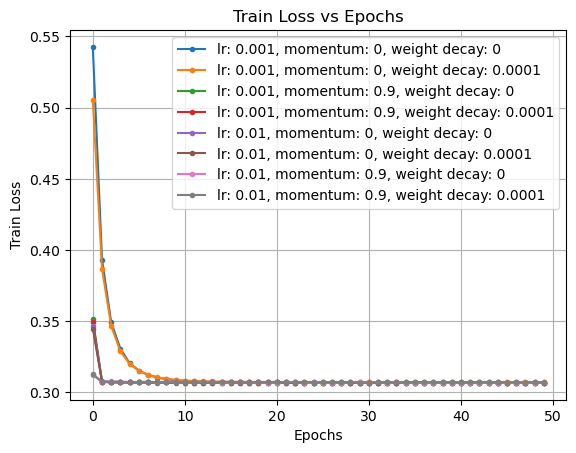

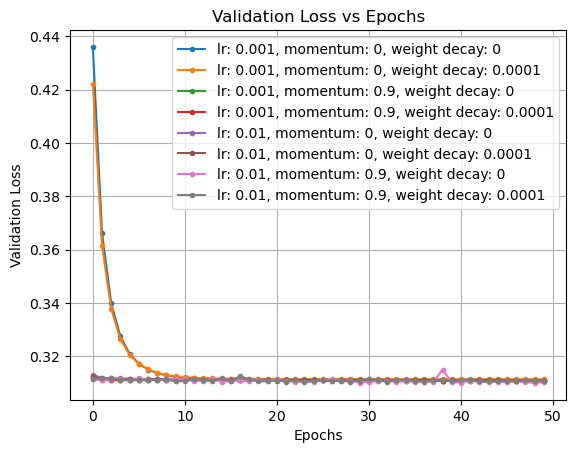

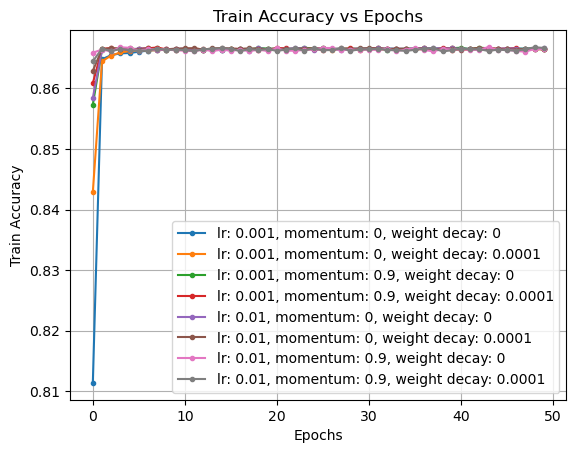

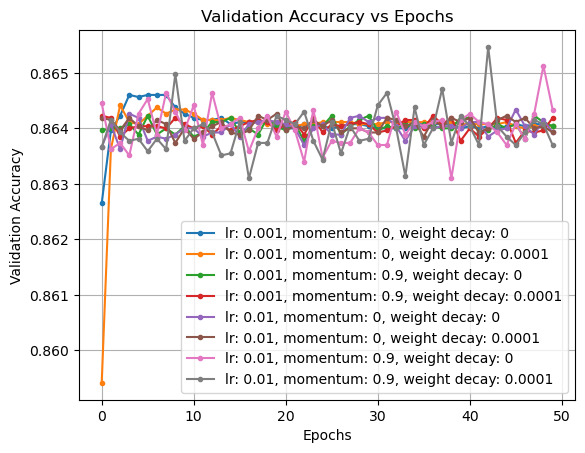

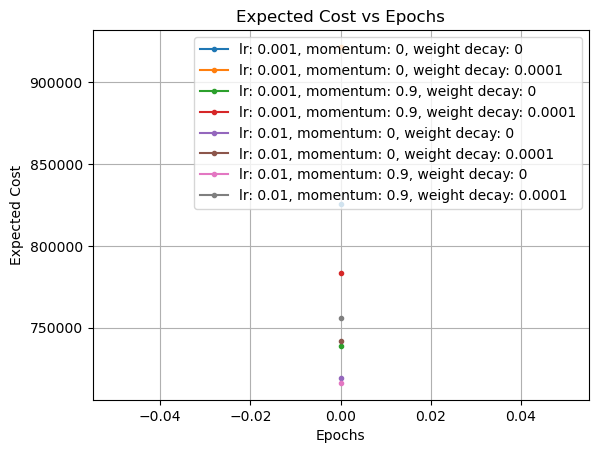

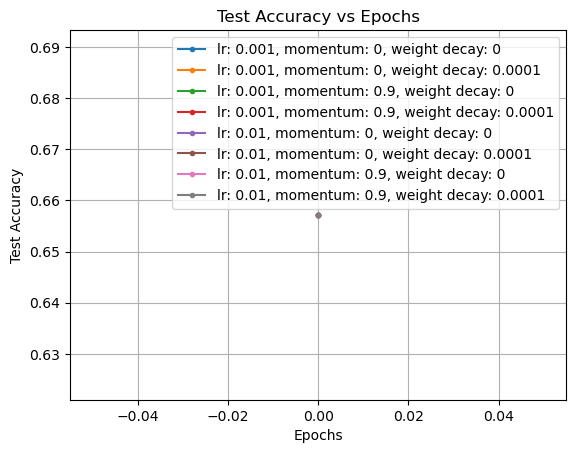

In [35]:
# plot train and validation loss for each hyperparameter combination
print(len(train_losses_list))
# plt.figure(figsize=(20, 10))
plt.figure()
plt.grid()
for i in range(len(lr_values)):
    for j in range(len(momentum_values)):
        for k in range(len(weight_decay_values)):
            print(i*4 + j*2 + k, i, j, k)
            plt.plot(train_losses_list[i*4 + j*2 + k], marker='.' ,label="lr: " + str(lr_values[i]) + ", momentum: " + str(momentum_values[j]) + ", weight decay: " + str(weight_decay_values[k]))
plt.legend()
plt.title("Train Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Train Loss")
plt.show()

plt.figure()
plt.grid()
for i in range(len(lr_values)):
    for j in range(len(momentum_values)):
        for k in range(len(weight_decay_values)):
            plt.plot(val_losses_list[i*4 + j*2 + k], marker='.' , label="lr: " + str(lr_values[i]) + ", momentum: " + str(momentum_values[j]) + ", weight decay: " + str(weight_decay_values[k]))
plt.legend()
plt.title("Validation Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.show()

# plot train and validation accuracy for each hyperparameter combination
plt.figure()
plt.grid()
for i in range(len(lr_values)):
    for j in range(len(momentum_values)):
        for k in range(len(weight_decay_values)):
            plt.plot(train_accuracies_list[i*4 + j*2 + k], marker='.' , label="lr: " + str(lr_values[i]) + ", momentum: " + str(momentum_values[j]) + ", weight decay: " + str(weight_decay_values[k]))
plt.legend()
plt.title("Train Accuracy vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Train Accuracy")
plt.show()

plt.figure()
plt.grid()
for i in range(len(lr_values)):
    for j in range(len(momentum_values)):
        for k in range(len(weight_decay_values)):
            plt.plot(val_accuracies_list[i*4 + j*2 + k], marker='.' , label="lr: " + str(lr_values[i]) + ", momentum: " + str(momentum_values[j]) + ", weight decay: " + str(weight_decay_values[k]))
plt.legend()
plt.title("Validation Accuracy vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.show()

# plot expected cost for each hyperparameter combination
plt.figure()
plt.grid()
for i in range(len(lr_values)):
    for j in range(len(momentum_values)):
        for k in range(len(weight_decay_values)):
            plt.plot(expected_costs_list[i*4 + j*2 + k], marker='.' , label="lr: " + str(lr_values[i]) + ", momentum: " + str(momentum_values[j]) + ", weight decay: " + str(weight_decay_values[k]))
plt.legend()
plt.title("Expected Cost vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Expected Cost")
plt.show()

# plot test accuracy for each hyperparameter combination
plt.figure()
plt.grid()
for i in range(len(lr_values)):
    for j in range(len(momentum_values)):
        for k in range(len(weight_decay_values)):
            plt.plot(test_accuracy_list[i*4 + j*2 + k], marker='.' , label="lr: " + str(lr_values[i]) + ", momentum: " + str(momentum_values[j]) + ", weight decay: " + str(weight_decay_values[k]))
plt.legend()
plt.title("Test Accuracy vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Test Accuracy")
plt.show()



# cost_sensitive_log_model = CostSensitiveLogisticRegression(input_dim=X_train.shape[1])

# optimizer = torch.optim.SGD(cost_sensitive_log_model.parameters(), lr=0.001)

# return_val = cost_sensitive_log_model.train_model(train_loader, val_loader, optimizer=optimizer, num_epochs=10, learning_rate=0.001)

# train_losses_cost_sensitive_lr, val_losses_cost_sensitive_lr, train_accuracies_cost_sensitive_lr, val_accuracies_cost_sensitive_lr, best_accuracy_cost_sensitive_lr, best_model_cost_sensitive_lr = return_val


# print("Cost of Cost Sensitive Logistic Regression Model: ", cost_sensitive_log_model.compute_expected_cost(test_loader))

# y_pred = cost_sensitive_log_model(X_test)
# y_pred = y_pred >= 0.5
# y_pred = y_pred.detach().numpy()
# y_pred = y_pred.astype(int)

# # select only first column of y_test
# y_test_label = []
# for i in range(len(y_test)):
#     y_test_label.append(y_test[i][0])

# # convert y_pred and y_test into list
# y_pred = y_pred.tolist()
# # y_test = y_test.tolist()
# # print precision, recall, f1 score
# print(classification_report(y_test_label, y_pred))

# # print accuracy
# print("Accuracy: ", accuracy_score(y_test_label, y_pred))

In [51]:
log_model = LogisticRegression(input_dim=X_train.shape[1])
return_val = log_model.train_model(train_loader, val_loader, num_epochs=10, learning_rate=0.001)
print("Cost of Logistic Regression Model: ", log_model.compute_expected_cost(test_loader))

# Display confusion matrix
y_pred = log_model(X_test)
y_pred = y_pred >= 0.5
y_pred = y_pred.detach().numpy()
y_pred = y_pred.astype(int)

# select only first column of y_test
y_test_label = []
for i in range(len(y_test)):
    y_test_label.append(y_test[i][0])

# convert y_pred and y_test into list
y_pred = y_pred.tolist()
# y_test = y_test.tolist()
# print precision, recall, f1 score
print(classification_report(y_test_label, y_pred))

# print accuracy
print("Accuracy: ", accuracy_score(y_test_label, y_pred))


Epoch: 1 	Training Loss: 0.395643 	Training Accuracy: 0.841928 	Validation Loss: 0.311979 	Validation Accuracy: 0.866200
Epoch: 2 	Training Loss: 0.307816 	Training Accuracy: 0.866496 	Validation Loss: 0.308780 	Validation Accuracy: 0.865974
Epoch: 3 	Training Loss: 0.307126 	Training Accuracy: 0.866428 	Validation Loss: 0.308638 	Validation Accuracy: 0.866019
Epoch: 4 	Training Loss: 0.306900 	Training Accuracy: 0.866534 	Validation Loss: 0.308384 	Validation Accuracy: 0.865794
Epoch: 5 	Training Loss: 0.306849 	Training Accuracy: 0.866670 	Validation Loss: 0.308209 	Validation Accuracy: 0.865884
Epoch: 6 	Training Loss: 0.306766 	Training Accuracy: 0.866331 	Validation Loss: 0.308220 	Validation Accuracy: 0.866381
Epoch: 7 	Training Loss: 0.306703 	Training Accuracy: 0.866670 	Validation Loss: 0.308156 	Validation Accuracy: 0.865884
Epoch: 8 	Training Loss: 0.306680 	Training Accuracy: 0.866457 	Validation Loss: 0.307915 	Validation Accuracy: 0.866336
Epoch: 9 	Training Loss: 0.30660

In [15]:
# Class for Neural Network
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(NeuralNetwork, self).__init__()
        # Defining the number of input nodes, hidden nodes and output nodes
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = 1
        # Defining the layers
        self.model = nn.Sequential(
            nn.Linear(self.input_dim, self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.output_dim),
            nn.Sigmoid()
        )

        self.loss_critetion = nn.BCELoss()
        
    def forward(self, x):
        # Forward pass through the network
        x = self.model(x)
        return x
    
    def compute_loss(self, y_pred, y_true, false_negative_cost):
        epsilon = 1e-7
        true_positive_cost = 4.0
        false_positive_cost = 4.0
        true_negative_cost = 0
        # print("False Negative Cost: ",false_negative_cost.reshape(-1,1).shape)
        
        # print("Y_pred Shape: ",y_pred.shape)
        # print("Y_true Shape: ",y_true.shape)

        # Compute the losses for true positives, false positives, true negatives, and false negatives
        # tp_loss = y_true * torch.log(y_pred + epsilon) * true_positive_cost
        # fp_loss = y_true * torch.log(1 - y_pred + epsilon) * false_positive_cost
        # tn_loss = (1 - y_true) * torch.log(1 - y_pred + epsilon) * true_negative_cost
        # fn_loss = (1 - y_true) * torch.log(y_pred + epsilon) * false_negative_cost
        
        tp_loss = y_true * y_pred * true_positive_cost
        fp_loss = (1 - y_true) * y_pred * false_positive_cost
        fn_loss = (y_true * (1 - y_pred)) * false_negative_cost.reshape(-1,1)
        # tn_loss = (1 - y_true) * (1 - y_pred) * true_negative_cost
        tn_loss = torch.multiply((1 - y_true), (1 - y_pred)) * true_negative_cost
        # print((1-y_true).shape)
        # print((1-y_pred).shape)

        # Compute the total loss
        # total_loss = y_true * (y_pred * true_positive_cost + (1 - y_pred) * false_negative_cost) + (1 - y_true) * (y_pred * false_positive_cost + (1 - y_pred) * true_negative_cost)

        # total_loss = total_loss.mean()
        total_loss = tp_loss + fp_loss + tn_loss + fn_loss
        # print(tp_loss.shape, fp_loss.shape, tn_loss.shape, fn_loss.shape)
        # print("Loss Shape: ",total_loss.shape)
        total_loss = total_loss.mean()

        return total_loss

    def compute_expected_cost(self, test_loader):
        self.eval()
        # compute the expected cost for the test data
        total_cost = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = self(data)
            false_neg_cost = target[:, 1]
            target = target[:, 0].view(-1, 1)
            loss = self.compute_loss(output, target, false_neg_cost)
            total_cost += loss.item() * data.size(0)
        return total_cost
    def train_model(self, train_loader, test_loader, optimizer, num_epochs, learning_rate):
        # Define the loss function and the optimizer
        criterion = self.loss_critetion
        # optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        
        self.train()

        # Lists to keep track of progress
        train_losses = []
        test_losses = []
        test_accuracies = []
        train_accuracies = []
        best_accuracy = 0
        best_model = None

        # Number of epochs
        n_epochs = num_epochs

        for epoch in range(n_epochs):
            # Monitor training loss
            train_loss = 0.0
            total_classified = 0
            correct_classified = 0
            self.train()
            for batch_idx, (data, target) in enumerate(train_loader):

                target = target[:, 0].view(-1, 1)
                # Clear the gradients of all optimized variables
                optimizer.zero_grad()
                # Forward pass: compute predicted outputs by passing inputs to the model
                output = self(data)
                # Calculate the batch loss
                loss = criterion(output, target)
                # Backward pass: compute gradient of the loss with respect to model parameters
                loss.backward()
                # Perform a single optimization step (parameter update)
                optimizer.step()
                # Update running training loss
                train_loss += loss.item() * data.size(0)
                # Calculate the number of correct classifications
                pred = output >= 0.5
                correct_classified += (pred == target).sum().item()
                total_classified += len(target)
        
            # Calculate average loss over an epoch
            train_loss = train_loss / len(train_loader.dataset)
    
            # Calculate training accuracy
            train_accuracy = correct_classified / total_classified
        
            # Append to the training loss and accuracy lists
            train_accuracies.append(train_accuracy)
            train_losses.append(train_loss)
        
            # Test the model for validation
            test_loss = 0.0
            total_classified = 0
            correct_classified = 0
            self.eval()
            for batch_idx, (data, target) in enumerate(test_loader):
                # Forward pass: compute predicted outputs by passing inputs to the model
                output = self(data)
                target = target[:, 0].view(-1, 1)
                # Calculate the batch loss
                loss = criterion(output, target)
                # Update running validation loss 
                test_loss += loss.item() * data.size(0)
                # Calculate the number of correct classifications
                pred = output >= 0.5
                correct_classified += (pred == target).sum().item()
                total_classified += len(target)
        
            # Calculate average loss over an epoch
            test_loss = test_loss / len(test_loader.dataset)
        
            # Calculate validation accuracy
            test_accuracy = correct_classified / total_classified
        
            # Append to the validation loss and accuracy lists
            test_accuracies.append(test_accuracy)
            test_losses.append(test_loss)
        
            # print both test and train loss and accuracy
            print('Epoch: {} \tTraining Loss: {:.6f} \tTraining Accuracy: {:.6f} \tValidation Loss: {:.6f} \tValidation Accuracy: {:.6f}'.format(epoch+1, train_loss, train_accuracy, test_loss, test_accuracy))
            
            if test_accuracy > best_accuracy:
                best_accuracy = test_accuracy
                # best_model = self.state_dict()
                # torch.save(best_model, 'best_model.pt')
                torch.save(self.state_dict(), 'best_model.pt')
            
        # print('Best Accuracy: ', best_accuracy)
        # Load the best model
        self.load_state_dict(torch.load('best_model.pt'))
        return train_losses, test_losses, train_accuracies, test_accuracies, best_accuracy, best_model
    
    def train_model2(self, train_loader, test_loader, optimizer, num_epochs, learning_rate):
        # Define the loss function and the optimizer
        criterion = self.loss_critetion
        # optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        
        self.train()

        # Lists to keep track of progress
        train_losses = []
        test_losses = []
        test_accuracies = []
        train_accuracies = []
        best_accuracy = float('inf')
        best_model = None

        # Number of epochs
        n_epochs = num_epochs

        for epoch in range(n_epochs):
            # Monitor training loss
            train_loss = 0.0
            total_classified = 0
            correct_classified = 0
            self.train()
            for batch_idx, (data, target) in enumerate(train_loader):

                target = target[:, 0].view(-1, 1)
                # Clear the gradients of all optimized variables
                optimizer.zero_grad()
                # Forward pass: compute predicted outputs by passing inputs to the model
                output = self(data)
                # Calculate the batch loss
                loss = criterion(output, target)
                # Backward pass: compute gradient of the loss with respect to model parameters
                loss.backward()
                # Perform a single optimization step (parameter update)
                optimizer.step()
                # Update running training loss
                train_loss += loss.item() * data.size(0)
                # Calculate the number of correct classifications
                pred = output >= 0.5
                correct_classified += (pred == target).sum().item()
                total_classified += len(target)
        
            # Calculate average loss over an epoch
            train_loss = train_loss / len(train_loader.dataset)
    
            # Calculate training accuracy
            train_accuracy = correct_classified / total_classified
        
            # Append to the training loss and accuracy lists
            train_accuracies.append(train_accuracy)
            train_losses.append(train_loss)
        
            # Test the model for validation
            test_loss = 0.0
            total_classified = 0
            correct_classified = 0
            self.eval()
            for batch_idx, (data, target) in enumerate(test_loader):
                # Forward pass: compute predicted outputs by passing inputs to the model
                output = self(data)
                target = target[:, 0].view(-1, 1)
                # Calculate the batch loss
                loss = criterion(output, target)
                # Update running validation loss 
                test_loss += loss.item() * data.size(0)
                # Calculate the number of correct classifications
                pred = output >= 0.5
                correct_classified += (pred == target).sum().item()
                total_classified += len(target)
        
            # Calculate average loss over an epoch
            test_loss = test_loss / len(test_loader.dataset)
        
            # Calculate validation accuracy
            test_accuracy = correct_classified / total_classified
        
            # Append to the validation loss and accuracy lists
            test_accuracies.append(test_accuracy)
            test_losses.append(test_loss)
            
            test_expected_cost = self.compute_expected_cost(test_loader)
        
            # print both test and train loss and accuracy
            print('Epoch: {} \tTraining Loss: {:.6f} \tTraining Accuracy: {:.6f} \tValidation Loss: {:.6f} \tValidation Accuracy: {:.6f}'.format(epoch+1, train_loss, train_accuracy, test_loss, test_accuracy))
            
            if test_expected_cost < best_accuracy:
                best_accuracy = test_expected_cost
                # best_model = self.state_dict()
                # torch.save(best_model, 'best_model.pt')
                torch.save(self.state_dict(), 'best_model.pt')
            
        # print('Best Accuracy: ', best_accuracy)
        # Load the best model
        self.load_state_dict(torch.load('best_model.pt'))
        return train_losses, test_losses, train_accuracies, test_accuracies, best_accuracy, best_model
    

Learning Rate:  0.001
Momentum:  0
Weight Decay:  0
Epoch: 1 	Training Loss: 0.606362 	Training Accuracy: 0.680749 	Validation Loss: 0.539210 	Validation Accuracy: 0.702566
Epoch: 2 	Training Loss: 0.486717 	Training Accuracy: 0.755421 	Validation Loss: 0.438042 	Validation Accuracy: 0.833823
Epoch: 3 	Training Loss: 0.395903 	Training Accuracy: 0.849417 	Validation Loss: 0.364331 	Validation Accuracy: 0.856514
Epoch: 4 	Training Loss: 0.343746 	Training Accuracy: 0.860622 	Validation Loss: 0.333774 	Validation Accuracy: 0.860390
Epoch: 5 	Training Loss: 0.325075 	Training Accuracy: 0.864009 	Validation Loss: 0.324324 	Validation Accuracy: 0.862610
Epoch: 6 	Training Loss: 0.319085 	Training Accuracy: 0.864918 	Validation Loss: 0.321175 	Validation Accuracy: 0.863438
Epoch: 7 	Training Loss: 0.316739 	Training Accuracy: 0.864889 	Validation Loss: 0.319780 	Validation Accuracy: 0.863551
Epoch: 8 	Training Loss: 0.315499 	Training Accuracy: 0.864967 	Validation Loss: 0.318933 	Validation

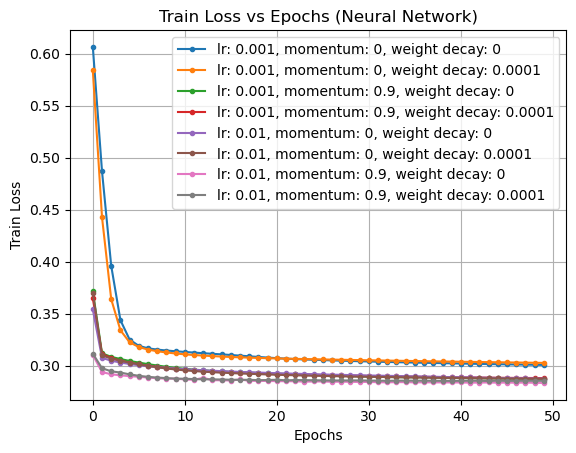

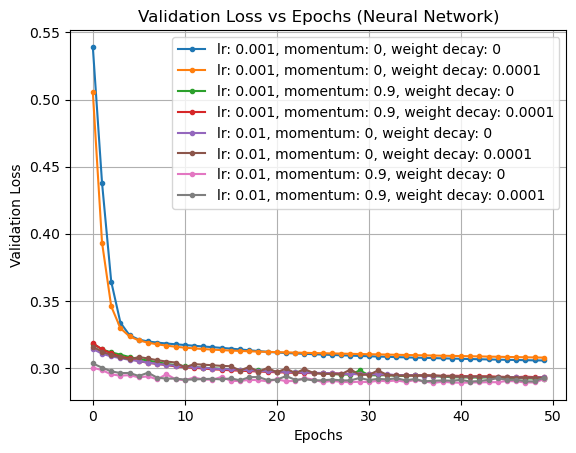

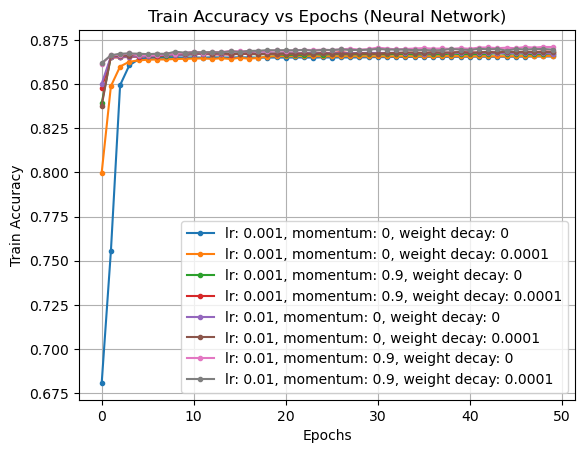

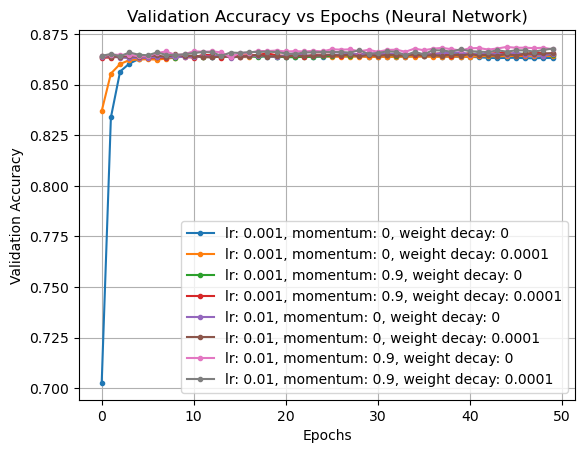

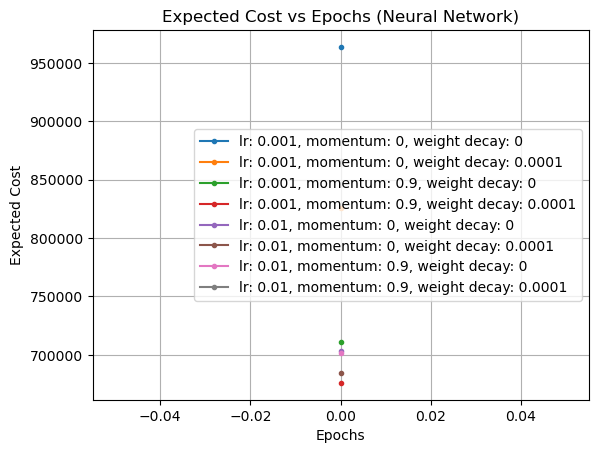

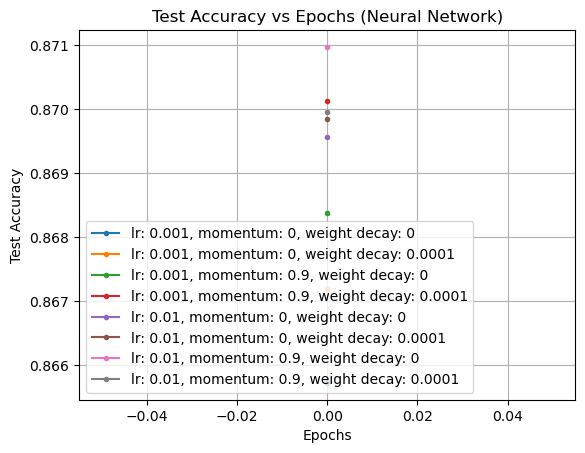

Best expected cost:  675990.731379509
Best test accuracy:  0.8701247389512897
Best learning rate:  0.001
Best momentum:  0
Best weight decay:  0.0001
Best test accuracy:  0.870971383417057
Best expected cost:  701519.4549217224
Best learning rate:  0.001
Best momentum:  0.9
Best weight decay:  0.0001


In [16]:
# select only first column of y_test
y_test_label = []
for i in range(len(y_test)):
    y_test_label.append(y_test[i][0])

lr_values = [0.001, 0.01]
momentum_values = [0, 0.9]
weight_decay_values = [0, 0.0001]

train_losses_list_nn = []
val_losses_list_nn = []
train_accuracies_list_nn = []
val_accuracies_list_nn = []
expected_costs_list_nn = []
test_accuracy_list_nn = []

for lr in lr_values:
    for momentum in momentum_values:
        for weight_decay in weight_decay_values:
            print("Learning Rate: ", lr)
            print("Momentum: ", momentum)
            print("Weight Decay: ", weight_decay)
            cost_sensitive_log_model = NeuralNetwork(input_dim=X_train.shape[1], hidden_dim=20)
            
            optimizer = torch.optim.SGD(cost_sensitive_log_model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
            
            return_val = cost_sensitive_log_model.train_model(train_loader, val_loader, optimizer=optimizer, num_epochs=50, learning_rate=lr)
            train_losses_cost_sensitive_lr, val_losses_cost_sensitive_lr, train_accuracies_cost_sensitive_lr, val_accuracies_cost_sensitive_lr, best_accuracy_cost_sensitive_lr, best_model_cost_sensitive_lr = return_val
            
            train_losses_list_nn.append(train_losses_cost_sensitive_lr)
            val_losses_list_nn.append(val_losses_cost_sensitive_lr)
            train_accuracies_list_nn.append(train_accuracies_cost_sensitive_lr)
            val_accuracies_list_nn.append(val_accuracies_cost_sensitive_lr)
            expected_costs_list_nn.append(cost_sensitive_log_model.compute_expected_cost(test_loader))
            y_pred = cost_sensitive_log_model(X_test)
            y_pred = y_pred >= 0.5
            y_pred = y_pred.detach().numpy()
            y_pred = y_pred.astype(int)
            y_pred = y_pred.tolist()
            test_accuracy_list_nn.append(accuracy_score(y_test_label, y_pred))

print(min(expected_costs_list_nn))
# plot train and validation loss for each hyperparameter combination
print(len(train_losses_list_nn))
# plt.figure(figsize=(20, 10))
plt.figure()
plt.grid()
for i in range(len(lr_values)):
    for j in range(len(momentum_values)):
        for k in range(len(weight_decay_values)):
            print(i*4 + j*2 + k, i, j, k)
            plt.plot(train_losses_list_nn[i*4 + j*2 + k], marker='.' ,label="lr: " + str(lr_values[i]) + ", momentum: " + str(momentum_values[j]) + ", weight decay: " + str(weight_decay_values[k]))
plt.legend()
plt.title("Train Loss vs Epochs (Neural Network)")
plt.xlabel("Epochs")
plt.ylabel("Train Loss")
plt.show()

plt.figure()
plt.grid()
for i in range(len(lr_values)):
    for j in range(len(momentum_values)):
        for k in range(len(weight_decay_values)):
            plt.plot(val_losses_list_nn[i*4 + j*2 + k], marker='.' , label="lr: " + str(lr_values[i]) + ", momentum: " + str(momentum_values[j]) + ", weight decay: " + str(weight_decay_values[k]))
plt.legend()
plt.title("Validation Loss vs Epochs (Neural Network)")
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.show()

# plot train and validation accuracy for each hyperparameter combination
plt.figure()
plt.grid()
for i in range(len(lr_values)):
    for j in range(len(momentum_values)):
        for k in range(len(weight_decay_values)):
            plt.plot(train_accuracies_list_nn[i*4 + j*2 + k], marker='.' , label="lr: " + str(lr_values[i]) + ", momentum: " + str(momentum_values[j]) + ", weight decay: " + str(weight_decay_values[k]))
plt.legend()
plt.title("Train Accuracy vs Epochs (Neural Network)")
plt.xlabel("Epochs")
plt.ylabel("Train Accuracy")
plt.show()

plt.figure()
plt.grid()
for i in range(len(lr_values)):
    for j in range(len(momentum_values)):
        for k in range(len(weight_decay_values)):
            plt.plot(val_accuracies_list_nn[i*4 + j*2 + k], marker='.' , label="lr: " + str(lr_values[i]) + ", momentum: " + str(momentum_values[j]) + ", weight decay: " + str(weight_decay_values[k]))
plt.legend()
plt.title("Validation Accuracy vs Epochs (Neural Network)")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.show()

# plot expected cost for each hyperparameter combination
plt.figure()
plt.grid()
for i in range(len(lr_values)):
    for j in range(len(momentum_values)):
        for k in range(len(weight_decay_values)):
            plt.plot(expected_costs_list_nn[i*4 + j*2 + k], marker='.' , label="lr: " + str(lr_values[i]) + ", momentum: " + str(momentum_values[j]) + ", weight decay: " + str(weight_decay_values[k]))
plt.legend()
plt.title("Expected Cost vs Epochs (Neural Network)")
plt.xlabel("Epochs")
plt.ylabel("Expected Cost")
plt.show()

# plot test accuracy for each hyperparameter combination
plt.figure()
plt.grid()
for i in range(len(lr_values)):
    for j in range(len(momentum_values)):
        for k in range(len(weight_decay_values)):
            plt.plot(test_accuracy_list_nn[i*4 + j*2 + k], marker='.' , label="lr: " + str(lr_values[i]) + ", momentum: " + str(momentum_values[j]) + ", weight decay: " + str(weight_decay_values[k]))
plt.legend()
plt.title("Test Accuracy vs Epochs (Neural Network)")
plt.xlabel("Epochs")
plt.ylabel("Test Accuracy")
plt.show()

# Print best expected cost and its accuracy and the model hyperparameters
best_expected_cost = min(expected_costs_list_nn)
best_expected_cost_index = expected_costs_list_nn.index(best_expected_cost)
best_test_accuracy = test_accuracy_list_nn[best_expected_cost_index]
best_lr = lr_values[best_expected_cost_index // 8]
best_momentum = momentum_values[(best_expected_cost_index % 8) // 4]
best_weight_decay = weight_decay_values[(best_expected_cost_index % 4) // 2]
print("Best expected cost: ", best_expected_cost)
print("Best test accuracy: ", best_test_accuracy)
print("Best learning rate: ", best_lr)
print("Best momentum: ", best_momentum)
print("Best weight decay: ", best_weight_decay)

# Print best accuracy and its expected cost and the model hyperparameters
best_test_accuracy = max(test_accuracy_list_nn)
best_test_accuracy_index = test_accuracy_list_nn.index(best_test_accuracy)
best_expected_cost = expected_costs_list_nn[best_test_accuracy_index]
best_lr = lr_values[best_test_accuracy_index // 8]
best_momentum = momentum_values[(best_test_accuracy_index % 8) // 4]
best_weight_decay = weight_decay_values[(best_test_accuracy_index % 4) // 2]
print("Best test accuracy: ", best_test_accuracy)
print("Best expected cost: ", best_expected_cost)
print("Best learning rate: ", best_lr)
print("Best momentum: ", best_momentum)
print("Best weight decay: ", best_weight_decay)

Learning Rate:  0.001
Momentum:  0
Weight Decay:  0
Epoch: 1 	Training Loss: 0.610039 	Training Accuracy: 0.700460 	Validation Loss: 0.529630 	Validation Accuracy: 0.793294
Epoch: 2 	Training Loss: 0.467538 	Training Accuracy: 0.829087 	Validation Loss: 0.413316 	Validation Accuracy: 0.850643
Epoch: 3 	Training Loss: 0.373424 	Training Accuracy: 0.859848 	Validation Loss: 0.348622 	Validation Accuracy: 0.862271
Epoch: 4 	Training Loss: 0.332242 	Training Accuracy: 0.865441 	Validation Loss: 0.327629 	Validation Accuracy: 0.864115
Epoch: 5 	Training Loss: 0.319745 	Training Accuracy: 0.865393 	Validation Loss: 0.321632 	Validation Accuracy: 0.864115
Epoch: 6 	Training Loss: 0.315853 	Training Accuracy: 0.865489 	Validation Loss: 0.319516 	Validation Accuracy: 0.863965
Epoch: 7 	Training Loss: 0.314247 	Training Accuracy: 0.865431 	Validation Loss: 0.318443 	Validation Accuracy: 0.864040
Epoch: 8 	Training Loss: 0.313273 	Training Accuracy: 0.865393 	Validation Loss: 0.317682 	Validation

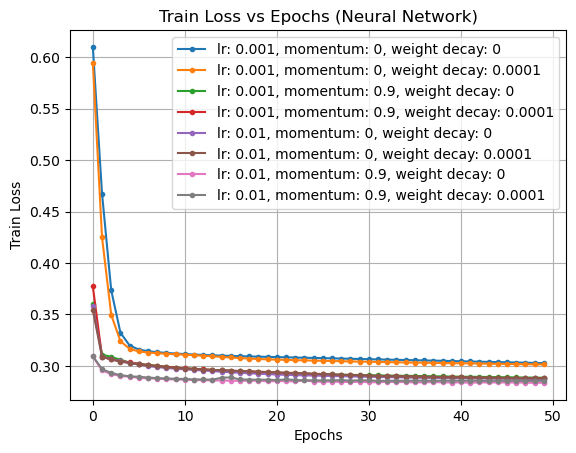

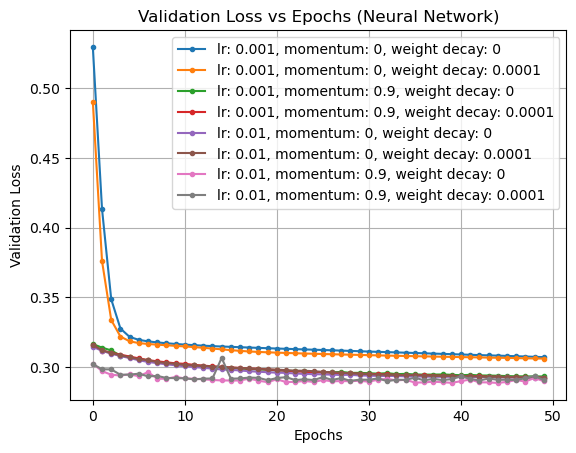

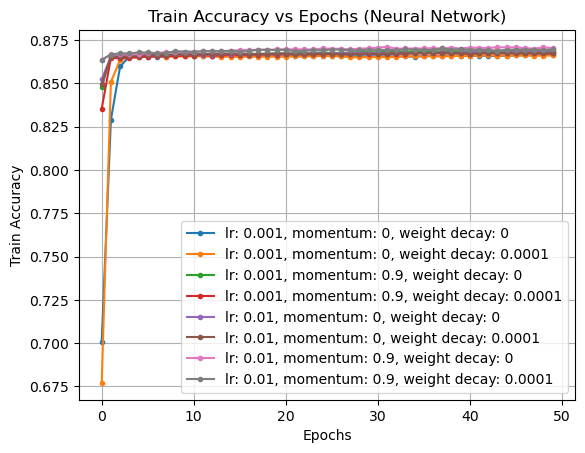

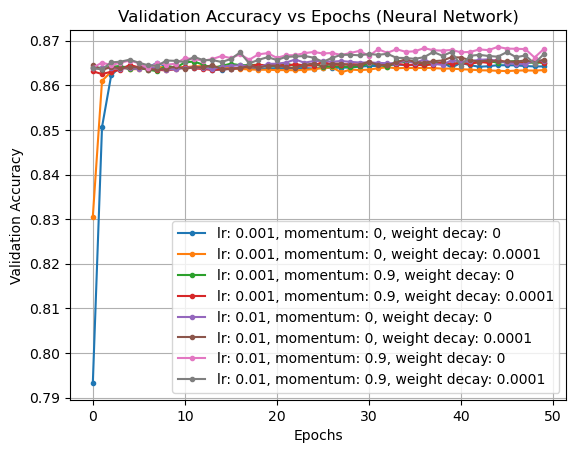

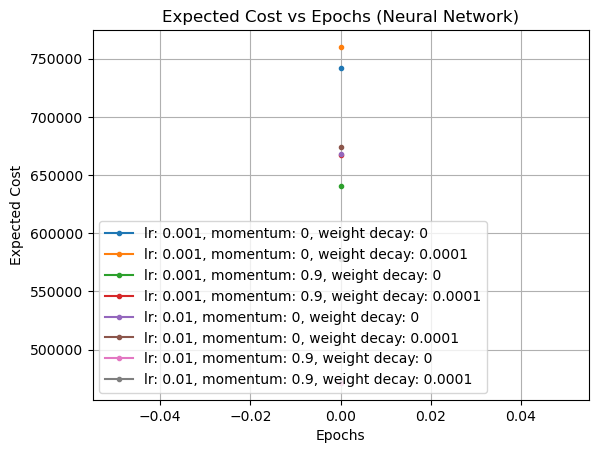

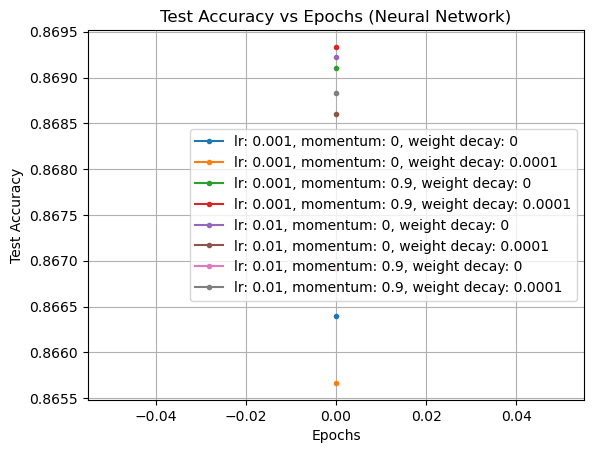

Best expected cost:  471436.78594851494
Best test accuracy:  0.8669074899813738
Best learning rate:  0.001
Best momentum:  0.9
Best weight decay:  0.0001
Best test accuracy:  0.8693345374499069
Best expected cost:  666867.8332881927
Best learning rate:  0.001
Best momentum:  0
Best weight decay:  0.0001


In [17]:
# select only first column of y_test
y_test_label = []
for i in range(len(y_test)):
    y_test_label.append(y_test[i][0])

lr_values = [0.001, 0.01]
momentum_values = [0, 0.9]
weight_decay_values = [0, 0.0001]

train_losses_list_nn2 = []
val_losses_list_nn2 = []
train_accuracies_list_nn2 = []
val_accuracies_list_nn2 = []
expected_costs_list_nn2 = []
test_accuracy_list_nn2 = []

for lr in lr_values:
    for momentum in momentum_values:
        for weight_decay in weight_decay_values:
            print("Learning Rate: ", lr)
            print("Momentum: ", momentum)
            print("Weight Decay: ", weight_decay)
            cost_sensitive_log_model = NeuralNetwork(input_dim=X_train.shape[1], hidden_dim=20)
            
            optimizer = torch.optim.SGD(cost_sensitive_log_model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
            
            return_val = cost_sensitive_log_model.train_model2(train_loader, val_loader, optimizer=optimizer, num_epochs=50, learning_rate=lr)
            train_losses_cost_sensitive_lr, val_losses_cost_sensitive_lr, train_accuracies_cost_sensitive_lr, val_accuracies_cost_sensitive_lr, best_accuracy_cost_sensitive_lr, best_model_cost_sensitive_lr = return_val
            
            train_losses_list_nn2.append(train_losses_cost_sensitive_lr)
            val_losses_list_nn2.append(val_losses_cost_sensitive_lr)
            train_accuracies_list_nn2.append(train_accuracies_cost_sensitive_lr)
            val_accuracies_list_nn2.append(val_accuracies_cost_sensitive_lr)
            expected_costs_list_nn2.append(cost_sensitive_log_model.compute_expected_cost(test_loader))
            y_pred = cost_sensitive_log_model(X_test)
            y_pred = y_pred >= 0.5
            y_pred = y_pred.detach().numpy()
            y_pred = y_pred.astype(int)
            y_pred = y_pred.tolist()
            test_accuracy_list_nn2.append(accuracy_score(y_test_label, y_pred))

print(min(expected_costs_list_nn2))
# plot train and validation loss for each hyperparameter combination
print(len(train_losses_list_nn2))
# plt.figure(figsize=(20, 10))
plt.figure()
plt.grid()
for i in range(len(lr_values)):
    for j in range(len(momentum_values)):
        for k in range(len(weight_decay_values)):
            print(i*4 + j*2 + k, i, j, k)
            plt.plot(train_losses_list_nn2[i*4 + j*2 + k], marker='.' ,label="lr: " + str(lr_values[i]) + ", momentum: " + str(momentum_values[j]) + ", weight decay: " + str(weight_decay_values[k]))
plt.legend()
plt.title("Train Loss vs Epochs (Neural Network)")
plt.xlabel("Epochs")
plt.ylabel("Train Loss")
plt.show()

plt.figure()
plt.grid()
for i in range(len(lr_values)):
    for j in range(len(momentum_values)):
        for k in range(len(weight_decay_values)):
            plt.plot(val_losses_list_nn2[i*4 + j*2 + k], marker='.' , label="lr: " + str(lr_values[i]) + ", momentum: " + str(momentum_values[j]) + ", weight decay: " + str(weight_decay_values[k]))
plt.legend()
plt.title("Validation Loss vs Epochs (Neural Network)")
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.show()

# plot train and validation accuracy for each hyperparameter combination
plt.figure()
plt.grid()
for i in range(len(lr_values)):
    for j in range(len(momentum_values)):
        for k in range(len(weight_decay_values)):
            plt.plot(train_accuracies_list_nn2[i*4 + j*2 + k], marker='.' , label="lr: " + str(lr_values[i]) + ", momentum: " + str(momentum_values[j]) + ", weight decay: " + str(weight_decay_values[k]))
plt.legend()
plt.title("Train Accuracy vs Epochs (Neural Network)")
plt.xlabel("Epochs")
plt.ylabel("Train Accuracy")
plt.show()

plt.figure()
plt.grid()
for i in range(len(lr_values)):
    for j in range(len(momentum_values)):
        for k in range(len(weight_decay_values)):
            plt.plot(val_accuracies_list_nn2[i*4 + j*2 + k], marker='.' , label="lr: " + str(lr_values[i]) + ", momentum: " + str(momentum_values[j]) + ", weight decay: " + str(weight_decay_values[k]))
plt.legend()
plt.title("Validation Accuracy vs Epochs (Neural Network)")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.show()

# plot expected cost for each hyperparameter combination
plt.figure()
plt.grid()
for i in range(len(lr_values)):
    for j in range(len(momentum_values)):
        for k in range(len(weight_decay_values)):
            plt.plot(expected_costs_list_nn2[i*4 + j*2 + k], marker='.' , label="lr: " + str(lr_values[i]) + ", momentum: " + str(momentum_values[j]) + ", weight decay: " + str(weight_decay_values[k]))
plt.legend()
plt.title("Expected Cost vs Epochs (Neural Network)")
plt.xlabel("Epochs")
plt.ylabel("Expected Cost")
plt.show()

# plot test accuracy for each hyperparameter combination
plt.figure()
plt.grid()
for i in range(len(lr_values)):
    for j in range(len(momentum_values)):
        for k in range(len(weight_decay_values)):
            plt.plot(test_accuracy_list_nn2[i*4 + j*2 + k], marker='.' , label="lr: " + str(lr_values[i]) + ", momentum: " + str(momentum_values[j]) + ", weight decay: " + str(weight_decay_values[k]))
plt.legend()
plt.title("Test Accuracy vs Epochs (Neural Network)")
plt.xlabel("Epochs")
plt.ylabel("Test Accuracy")
plt.show()

# Print best expected cost and its accuracy and the model hyperparameters
best_expected_cost = min(expected_costs_list_nn2)
best_expected_cost_index = expected_costs_list_nn2.index(best_expected_cost)
best_test_accuracy = test_accuracy_list_nn2[best_expected_cost_index]
best_lr = lr_values[best_expected_cost_index // 8]
best_momentum = momentum_values[(best_expected_cost_index % 8) // 4]
best_weight_decay = weight_decay_values[(best_expected_cost_index % 4) // 2]
print("Best expected cost: ", best_expected_cost)
print("Best test accuracy: ", best_test_accuracy)
print("Best learning rate: ", best_lr)
print("Best momentum: ", best_momentum)
print("Best weight decay: ", best_weight_decay)

# Print best accuracy and its expected cost and the model hyperparameters
best_test_accuracy = max(test_accuracy_list_nn2)
best_test_accuracy_index = test_accuracy_list_nn2.index(best_test_accuracy)
best_expected_cost = expected_costs_list_nn2[best_test_accuracy_index]
best_lr = lr_values[best_test_accuracy_index // 8]
best_momentum = momentum_values[(best_test_accuracy_index % 8) // 4]
best_weight_decay = weight_decay_values[(best_test_accuracy_index % 4) // 2]
print("Best test accuracy: ", best_test_accuracy)
print("Best expected cost: ", best_expected_cost)
print("Best learning rate: ", best_lr)
print("Best momentum: ", best_momentum)
print("Best weight decay: ", best_weight_decay)

In [52]:
neural_network_model = NeuralNetwork(input_dim=X_train.shape[1], hidden_dim=20)
return_val = neural_network_model.train_model(train_loader, val_loader, num_epochs=10, learning_rate=0.001)
print("Cost of NN Model: ", neural_network_model.compute_expected_cost(test_loader))

# Display confusion matrix
y_pred = neural_network_model(X_test)
y_pred = y_pred >= 0.5
y_pred = y_pred.detach().numpy()
y_pred = y_pred.astype(int)

# select only first column of y_test
y_test_label = []
for i in range(len(y_test)):
    y_test_label.append(y_test[i][0])

# convert y_pred and y_test into list
y_pred = y_pred.tolist()
# y_test = y_test.tolist()
# print precision, recall, f1 score
print(classification_report(y_test_label, y_pred))

# print accuracy
print("Accuracy: ", accuracy_score(y_test_label, y_pred))

Epoch: 1 	Training Loss: 0.330601 	Training Accuracy: 0.859761 	Validation Loss: 0.304615 	Validation Accuracy: 0.865432
Epoch: 2 	Training Loss: 0.298885 	Training Accuracy: 0.865964 	Validation Loss: 0.297793 	Validation Accuracy: 0.866019
Epoch: 3 	Training Loss: 0.294928 	Training Accuracy: 0.866776 	Validation Loss: 0.295712 	Validation Accuracy: 0.866290
Epoch: 4 	Training Loss: 0.293310 	Training Accuracy: 0.866680 	Validation Loss: 0.294181 	Validation Accuracy: 0.866290
Epoch: 5 	Training Loss: 0.292167 	Training Accuracy: 0.866834 	Validation Loss: 0.294906 	Validation Accuracy: 0.866561
Epoch: 6 	Training Loss: 0.291547 	Training Accuracy: 0.867047 	Validation Loss: 0.293744 	Validation Accuracy: 0.866787
Epoch: 7 	Training Loss: 0.291053 	Training Accuracy: 0.867376 	Validation Loss: 0.293817 	Validation Accuracy: 0.867374
Epoch: 8 	Training Loss: 0.290609 	Training Accuracy: 0.867154 	Validation Loss: 0.292402 	Validation Accuracy: 0.866561
Epoch: 9 	Training Loss: 0.29013

In [18]:
# Cost Sensitive Neural Network Model
class CostSensitiveNeuralNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(CostSensitiveNeuralNetwork, self).__init__()
        # Defining the number of input nodes, hidden nodes and output nodes
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = 1
                # Defining the layers
        self.model = nn.Sequential(
            nn.Linear(self.input_dim, self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.output_dim),
            nn.Sigmoid()
        )
        
        self.loss_critetion = self.compute_loss
    
    def forward(self, x):
        # Forward pass through the network
        x = self.model(x)
        return x
    
    def compute_loss(self, y_pred, y_true, false_negative_cost):
        epsilon = 1e-7
        true_positive_cost = 4.0
        false_positive_cost = 4.0
        true_negative_cost = 0
        # print("False Negative Cost: ",false_negative_cost.reshape(-1,1).shape)
        
        # print("Y_pred Shape: ",y_pred.shape)
        # print("Y_true Shape: ",y_true.shape)

        # Compute the losses for true positives, false positives, true negatives, and false negatives
        # tp_loss = y_true * torch.log(y_pred + epsilon) * true_positive_cost
        # fp_loss = y_true * torch.log(1 - y_pred + epsilon) * false_positive_cost
        # tn_loss = (1 - y_true) * torch.log(1 - y_pred + epsilon) * true_negative_cost
        # fn_loss = (1 - y_true) * torch.log(y_pred + epsilon) * false_negative_cost
        
        tp_loss = y_true * y_pred * true_positive_cost
        fp_loss = (1 - y_true) * y_pred * false_positive_cost
        fn_loss = (y_true * (1 - y_pred)) * false_negative_cost.reshape(-1,1)
        # tn_loss = (1 - y_true) * (1 - y_pred) * true_negative_cost
        tn_loss = torch.multiply((1 - y_true), (1 - y_pred)) * true_negative_cost
        # print((1-y_true).shape)
        # print((1-y_pred).shape)

        # Compute the total loss
        # total_loss = y_true * (y_pred * true_positive_cost + (1 - y_pred) * false_negative_cost) + (1 - y_true) * (y_pred * false_positive_cost + (1 - y_pred) * true_negative_cost)

        # total_loss = total_loss.mean()
        total_loss = tp_loss + fp_loss + tn_loss + fn_loss
        # print(tp_loss.shape, fp_loss.shape, tn_loss.shape, fn_loss.shape)
        # print("Loss Shape: ",total_loss.shape)
        total_loss = total_loss.mean()

        return total_loss
    
    def compute_expected_cost(self, test_loader):
        # compute the expected cost for the test data
        total_cost = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = self(data)
            false_neg_cost = target[:, 1]
            target = target[:, 0].view(-1, 1)
            loss = self.compute_loss(output, target, false_neg_cost)
            total_cost += loss.item() * data.size(0)
        return total_cost
    
    def train_model(self, train_loader, test_loader, optimizer, num_epochs, learning_rate):
        # Define the loss function and the optimizer
        criterion = self.compute_loss
        # optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        
        self.train()

        # Lists to keep track of progress
        train_losses = []
        test_losses = []
        test_accuracies = []
        train_accuracies = []
        best_accuracy = 0
        best_model = None

        # Number of epochs
        n_epochs = num_epochs

        for epoch in range(n_epochs):
            # Monitor training loss
            train_loss = 0.0
            total_classified = 0
            correct_classified = 0
            self.train()
            for batch_idx, (data, target) in enumerate(train_loader):
                # Clear the gradients of all optimized variables
                optimizer.zero_grad()
                # Forward pass: compute predicted outputs by passing inputs to the model
                output = self(data)
                false_neg_cost = target[:, 1]
                target = target[:, 0].view(-1, 1)
                # Calculate the batch loss
                loss = criterion(output, target, false_neg_cost)
                # Backward pass: compute gradient of the loss with respect to model parameters
                loss.backward()
                # Perform a single optimization step (parameter update)
                optimizer.step()
                # Update running training loss
                train_loss += loss.item() * data.size(0)
                # Calculate the number of correct classifications
                pred = output >= 0.5
                correct_classified += (pred == target).sum().item()
                total_classified += len(target)               
            
            # Calculate average loss over an epoch
            train_loss = train_loss / len(train_loader.dataset)
            
            # Calculate training accuracy
            train_accuracy = correct_classified / total_classified
        
            # Append to the training loss and accuracy lists
            train_accuracies.append(train_accuracy)
            train_losses.append(train_loss)

            # Test the model for validation
            test_loss = 0.0
            total_classified = 0
            correct_classified = 0
            self.eval()
            for batch_idx, (data, target) in enumerate(test_loader):
                # Forward pass: compute predicted outputs by passing inputs to the model
                output = self(data)
                false_neg_cost = target[:, 1]
                target = target[:, 0].view(-1, 1)
                # Calculate the batch loss
                loss = criterion(output, target, false_neg_cost)
                # Update running validation loss 
                test_loss += loss.item() * data.size(0)
                # Calculate the number of correct classifications
                pred = output >= 0.5
                correct_classified += (pred == target).sum().item()
                total_classified += len(target)
        
            # Calculate average loss over an epoch
            test_loss = test_loss / len(test_loader.dataset)
        
            # Calculate validation accuracy
            test_accuracy = correct_classified / total_classified
            
            # Append to the validation loss and accuracy lists
            test_accuracies.append(test_accuracy)
            test_losses.append(test_loss)
        
            # print both test and train loss and accuracy
            print('Epoch: {} \tTraining Loss: {:.6f} \tTraining Accuracy: {:.6f} \tValidation Loss: {:.6f} \tValidation Accuracy: {:.6f}'.format(epoch+1, train_loss, train_accuracy, test_loss, test_accuracy))
        
            if test_accuracy > best_accuracy:
                best_accuracy = test_accuracy
                # best_model = self.state_dict()
                # torch.save(best_model, 'best_model.pt')
                torch.save(self.state_dict(), 'best_model.pt')
                
        # print('Best Accuracy: ', best_accuracy)
        # Load the best model
        self.load_state_dict(torch.load('best_model.pt'))
        return train_losses, test_losses, train_accuracies, test_accuracies, best_accuracy, best_model
      
    def train_model2(self, train_loader, test_loader, optimizer, num_epochs, learning_rate):
        # Define the loss function and the optimizer
        criterion = self.compute_loss
        # optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        
        self.train()

        # Lists to keep track of progress
        train_losses = []
        test_losses = []
        test_accuracies = []
        train_accuracies = []
        best_expected_cost = float('inf')
        best_model = None

        # Number of epochs
        n_epochs = num_epochs

        for epoch in range(n_epochs):
            # Monitor training loss
            train_loss = 0.0
            total_classified = 0
            correct_classified = 0
            self.train()
            for batch_idx, (data, target) in enumerate(train_loader):
                # Clear the gradients of all optimized variables
                optimizer.zero_grad()
                # Forward pass: compute predicted outputs by passing inputs to the model
                output = self(data)
                false_neg_cost = target[:, 1]
                target = target[:, 0].view(-1, 1)
                # Calculate the batch loss
                loss = criterion(output, target, false_neg_cost)
                # Backward pass: compute gradient of the loss with respect to model parameters
                loss.backward()
                # Perform a single optimization step (parameter update)
                optimizer.step()
                # Update running training loss
                train_loss += loss.item() * data.size(0)
                # Calculate the number of correct classifications
                pred = output >= 0.5
                correct_classified += (pred == target).sum().item()
                total_classified += len(target)               
            
            # Calculate average loss over an epoch
            train_loss = train_loss / len(train_loader.dataset)
            
            # Calculate training accuracy
            train_accuracy = correct_classified / total_classified
        
            # Append to the training loss and accuracy lists
            train_accuracies.append(train_accuracy)
            train_losses.append(train_loss)

            # Test the model for validation
            test_loss = 0.0
            total_classified = 0
            correct_classified = 0
            self.eval()
            for batch_idx, (data, target) in enumerate(test_loader):
                # Forward pass: compute predicted outputs by passing inputs to the model
                output = self(data)
                false_neg_cost = target[:, 1]
                target = target[:, 0].view(-1, 1)
                # Calculate the batch loss
                loss = criterion(output, target, false_neg_cost)
                # Update running validation loss 
                test_loss += loss.item() * data.size(0)
                # Calculate the number of correct classifications
                pred = output >= 0.5
                correct_classified += (pred == target).sum().item()
                total_classified += len(target)
        
            # Calculate average loss over an epoch
            test_loss = test_loss / len(test_loader.dataset)
        
            # Calculate validation accuracy
            test_accuracy = correct_classified / total_classified
            
            # Append to the validation loss and accuracy lists
            test_accuracies.append(test_accuracy)
            test_losses.append(test_loss)
            best_expected_cost = self.compute_expected_cost(test_loader)
        
            # print both test and train loss and accuracy
            print('Epoch: {} \tTraining Loss: {:.6f} \tTraining Accuracy: {:.6f} \tValidation Loss: {:.6f} \tValidation Accuracy: {:.6f}'.format(epoch+1, train_loss, train_accuracy, test_loss, test_accuracy))
        
            if test_accuracy > best_expected_cost:
                best_expected_cost = test_accuracy
                # best_model = self.state_dict()
                # torch.save(best_model, 'best_model.pt')
                torch.save(self.state_dict(), 'best_model.pt')
                
        # print('Best Accuracy: ', best_accuracy)
        # Load the best model
        self.load_state_dict(torch.load('best_model.pt'))
        return train_losses, test_losses, train_accuracies, test_accuracies, best_expected_cost, best_model
      

Learning Rate:  0.001
Momentum:  0
Weight Decay:  0
Epoch: 1 	Training Loss: 4.027967 	Training Accuracy: 0.363027 	Validation Loss: 3.120218 	Validation Accuracy: 0.590615
Epoch: 2 	Training Loss: 2.854467 	Training Accuracy: 0.623968 	Validation Loss: 2.738494 	Validation Accuracy: 0.638632
Epoch: 3 	Training Loss: 2.704958 	Training Accuracy: 0.643195 	Validation Loss: 2.683301 	Validation Accuracy: 0.646497
Epoch: 4 	Training Loss: 2.665018 	Training Accuracy: 0.648430 	Validation Loss: 2.660126 	Validation Accuracy: 0.649319
Epoch: 5 	Training Loss: 2.644536 	Training Accuracy: 0.651275 	Validation Loss: 2.647274 	Validation Accuracy: 0.653007
Epoch: 6 	Training Loss: 2.631420 	Training Accuracy: 0.653384 	Validation Loss: 2.639282 	Validation Accuracy: 0.656243
Epoch: 7 	Training Loss: 2.622765 	Training Accuracy: 0.656413 	Validation Loss: 2.633281 	Validation Accuracy: 0.656657
Epoch: 8 	Training Loss: 2.616115 	Training Accuracy: 0.657148 	Validation Loss: 2.629191 	Validation

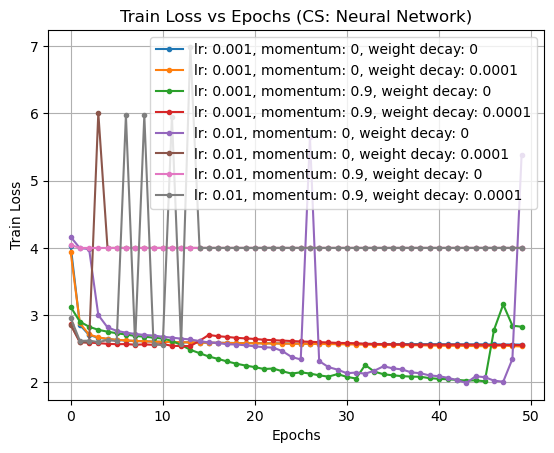

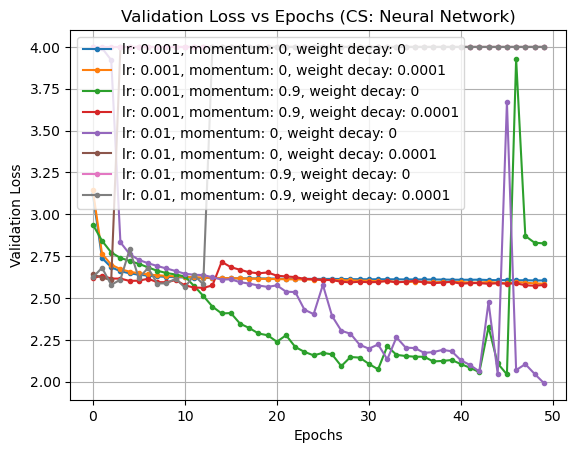

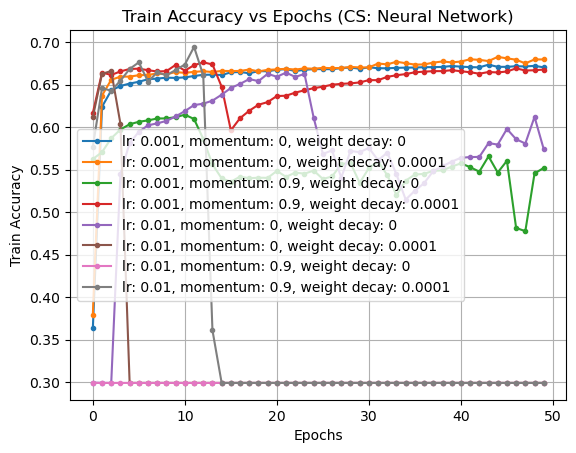

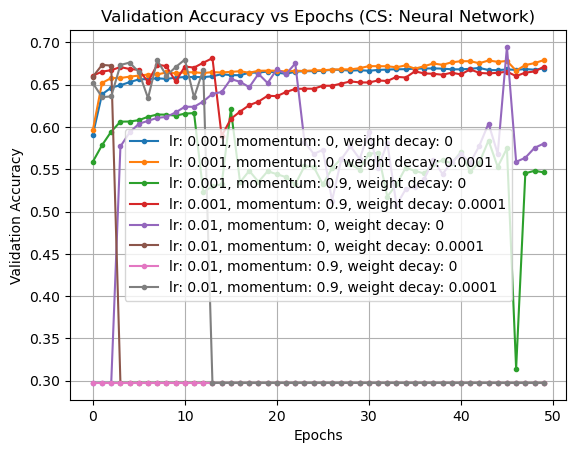

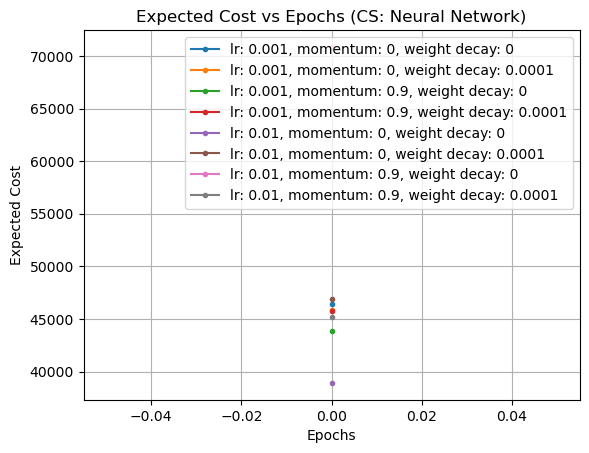

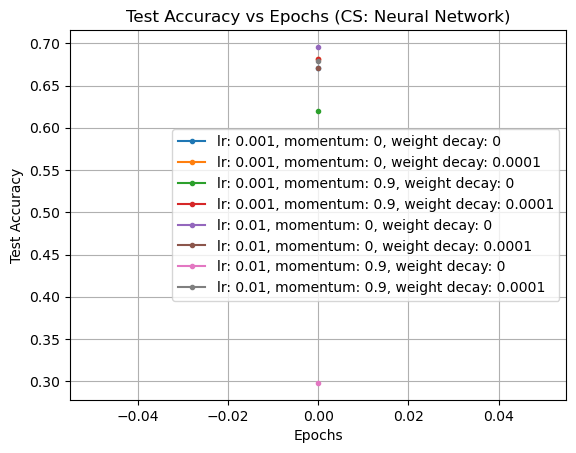

Best expected cost:  38915.38321888447
Best test accuracy:  0.6956595360388328
Best learning rate:  0.001
Best momentum:  0.9
Best weight decay:  0
Best test accuracy:  0.6956595360388328
Best expected cost:  38915.38321888447
Best learning rate:  0.001
Best momentum:  0.9
Best weight decay:  0


In [19]:
# select only first column of y_test
y_test_label = []
for i in range(len(y_test)):
    y_test_label.append(y_test[i][0])

lr_values = [0.001, 0.01]
momentum_values = [0, 0.9]
weight_decay_values = [0, 0.0001]

train_losses_list_nn_cs = []
val_losses_list_nn_cs = []
train_accuracies_list_nn_cs = []
val_accuracies_list_nn_cs = []
expected_costs_list_nn_cs = []
test_accuracy_list_nn_cs = []

for lr in lr_values:
    for momentum in momentum_values:
        for weight_decay in weight_decay_values:
            print("Learning Rate: ", lr)
            print("Momentum: ", momentum)
            print("Weight Decay: ", weight_decay)
            cost_sensitive_log_model = CostSensitiveNeuralNetwork(input_dim=X_train.shape[1], hidden_dim=20)
            
            optimizer = torch.optim.SGD(cost_sensitive_log_model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
            
            return_val = cost_sensitive_log_model.train_model(train_loader, val_loader, optimizer=optimizer, num_epochs=50, learning_rate=lr)
            train_losses_cost_sensitive_lr, val_losses_cost_sensitive_lr, train_accuracies_cost_sensitive_lr, val_accuracies_cost_sensitive_lr, best_accuracy_cost_sensitive_lr, best_model_cost_sensitive_lr = return_val
            
            train_losses_list_nn_cs.append(train_losses_cost_sensitive_lr)
            val_losses_list_nn_cs.append(val_losses_cost_sensitive_lr)
            train_accuracies_list_nn_cs.append(train_accuracies_cost_sensitive_lr)
            val_accuracies_list_nn_cs.append(val_accuracies_cost_sensitive_lr)
            expected_costs_list_nn_cs.append(cost_sensitive_log_model.compute_expected_cost(test_loader))
            y_pred = cost_sensitive_log_model(X_test)
            y_pred = y_pred >= 0.5
            y_pred = y_pred.detach().numpy()
            y_pred = y_pred.astype(int)
            y_pred = y_pred.tolist()
            test_accuracy_list_nn_cs.append(accuracy_score(y_test_label, y_pred))

print(min(expected_costs_list_nn_cs))
# plot train and validation loss for each hyperparameter combination
print(len(train_losses_list_nn_cs))
# plt.figure(figsize=(20, 10))
plt.figure()
plt.grid()
for i in range(len(lr_values)):
    for j in range(len(momentum_values)):
        for k in range(len(weight_decay_values)):
            print(i*4 + j*2 + k, i, j, k)
            plt.plot(train_losses_list_nn_cs[i*4 + j*2 + k], marker='.' ,label="lr: " + str(lr_values[i]) + ", momentum: " + str(momentum_values[j]) + ", weight decay: " + str(weight_decay_values[k]))
plt.legend()
plt.title("Train Loss vs Epochs (CS: Neural Network)")
plt.xlabel("Epochs")
plt.ylabel("Train Loss")
plt.show()

plt.figure()
plt.grid()
for i in range(len(lr_values)):
    for j in range(len(momentum_values)):
        for k in range(len(weight_decay_values)):
            plt.plot(val_losses_list_nn_cs[i*4 + j*2 + k], marker='.' , label="lr: " + str(lr_values[i]) + ", momentum: " + str(momentum_values[j]) + ", weight decay: " + str(weight_decay_values[k]))
plt.legend()
plt.title("Validation Loss vs Epochs (CS: Neural Network)")
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.show()

# plot train and validation accuracy for each hyperparameter combination
plt.figure()
plt.grid()
for i in range(len(lr_values)):
    for j in range(len(momentum_values)):
        for k in range(len(weight_decay_values)):
            plt.plot(train_accuracies_list_nn_cs[i*4 + j*2 + k], marker='.' , label="lr: " + str(lr_values[i]) + ", momentum: " + str(momentum_values[j]) + ", weight decay: " + str(weight_decay_values[k]))
plt.legend()
plt.title("Train Accuracy vs Epochs (CS: Neural Network)")
plt.xlabel("Epochs")
plt.ylabel("Train Accuracy")
plt.show()

plt.figure()
plt.grid()
for i in range(len(lr_values)):
    for j in range(len(momentum_values)):
        for k in range(len(weight_decay_values)):
            plt.plot(val_accuracies_list_nn_cs[i*4 + j*2 + k], marker='.' , label="lr: " + str(lr_values[i]) + ", momentum: " + str(momentum_values[j]) + ", weight decay: " + str(weight_decay_values[k]))
plt.legend()
plt.title("Validation Accuracy vs Epochs (CS: Neural Network)")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.show()

# plot expected cost for each hyperparameter combination
plt.figure()
plt.grid()
for i in range(len(lr_values)):
    for j in range(len(momentum_values)):
        for k in range(len(weight_decay_values)):
            plt.plot(expected_costs_list_nn_cs[i*4 + j*2 + k], marker='.' , label="lr: " + str(lr_values[i]) + ", momentum: " + str(momentum_values[j]) + ", weight decay: " + str(weight_decay_values[k]))
plt.legend()
plt.title("Expected Cost vs Epochs (CS: Neural Network)")
plt.xlabel("Epochs")
plt.ylabel("Expected Cost")
plt.show()

# plot test accuracy for each hyperparameter combination
plt.figure()
plt.grid()
for i in range(len(lr_values)):
    for j in range(len(momentum_values)):
        for k in range(len(weight_decay_values)):
            plt.plot(test_accuracy_list_nn_cs[i*4 + j*2 + k], marker='.' , label="lr: " + str(lr_values[i]) + ", momentum: " + str(momentum_values[j]) + ", weight decay: " + str(weight_decay_values[k]))
plt.legend()
plt.title("Test Accuracy vs Epochs (CS: Neural Network)")
plt.xlabel("Epochs")
plt.ylabel("Test Accuracy")
plt.show()

# Print best expected cost and its accuracy and the model hyperparameters
best_expected_cost = min(expected_costs_list_nn_cs)
best_expected_cost_index = expected_costs_list_nn_cs.index(best_expected_cost)
best_test_accuracy = test_accuracy_list_nn_cs[best_expected_cost_index]
best_lr = lr_values[best_expected_cost_index // 8]
best_momentum = momentum_values[(best_expected_cost_index % 8) // 4]
best_weight_decay = weight_decay_values[(best_expected_cost_index % 4) // 2]
print("Best expected cost: ", best_expected_cost)
print("Best test accuracy: ", best_test_accuracy)
print("Best learning rate: ", best_lr)
print("Best momentum: ", best_momentum)
print("Best weight decay: ", best_weight_decay)

# Print best accuracy and its expected cost and the model hyperparameters
best_test_accuracy = max(test_accuracy_list_nn_cs)
best_test_accuracy_index = test_accuracy_list_nn_cs.index(best_test_accuracy)
best_expected_cost = expected_costs_list_nn_cs[best_test_accuracy_index]
best_lr = lr_values[best_test_accuracy_index // 8]
best_momentum = momentum_values[(best_test_accuracy_index % 8) // 4]
best_weight_decay = weight_decay_values[(best_test_accuracy_index % 4) // 2]
print("Best test accuracy: ", best_test_accuracy)
print("Best expected cost: ", best_expected_cost)
print("Best learning rate: ", best_lr)
print("Best momentum: ", best_momentum)
print("Best weight decay: ", best_weight_decay)

0 0 0 0
1 0 0 1
2 0 1 0
3 0 1 1
4 1 0 0
5 1 0 1
6 1 1 0
7 1 1 1


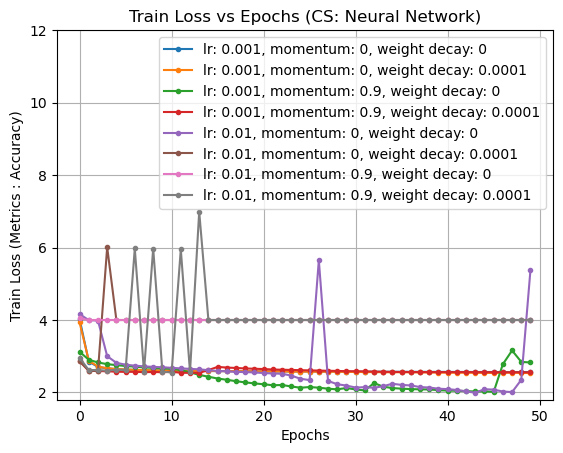

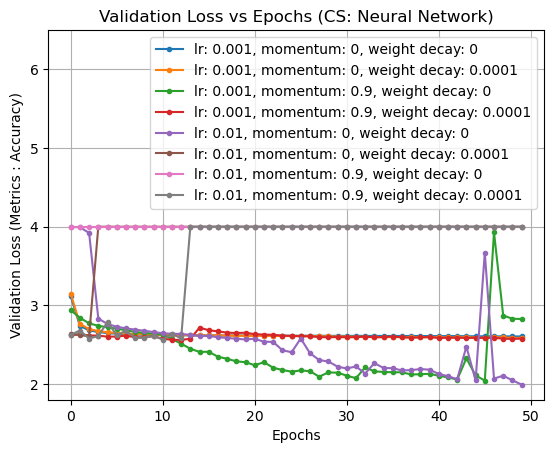

/home/cs20btech11063/anaconda3/envs/gpu_env2/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


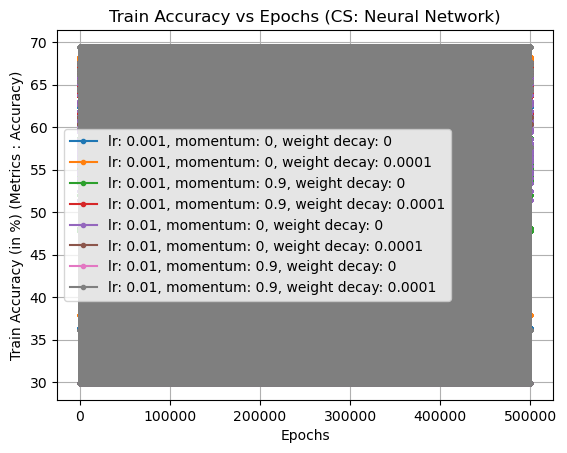

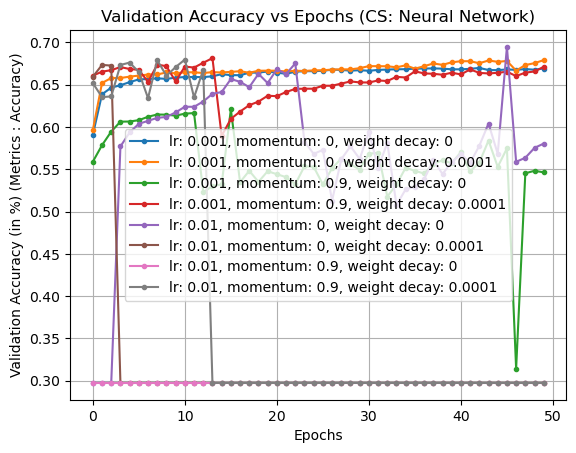

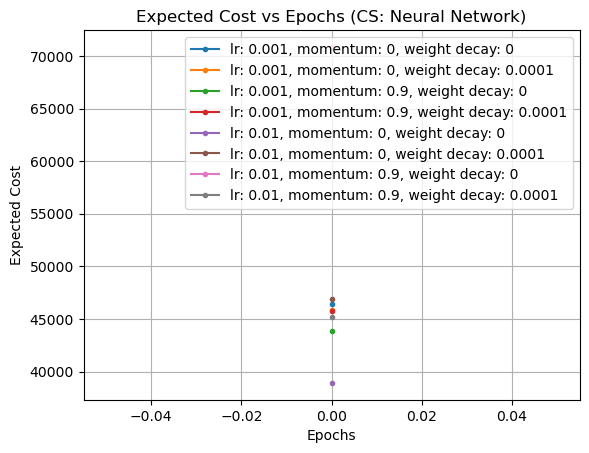

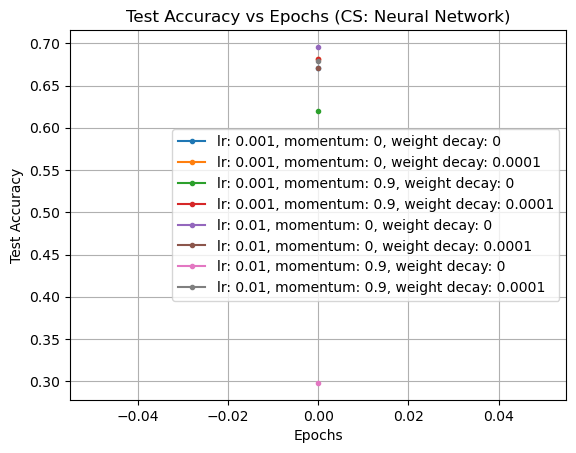

In [81]:
plt.figure()
plt.grid()
for i in range(len(lr_values)):
    for j in range(len(momentum_values)):
        for k in range(len(weight_decay_values)):
            print(i*4 + j*2 + k, i, j, k)
            plt.plot(train_losses_list_nn_cs[i*4 + j*2 + k], marker='.' ,label="lr: " + str(lr_values[i]) + ", momentum: " + str(momentum_values[j]) + ", weight decay: " + str(weight_decay_values[k]))
plt.legend()
plt.title("Train Loss vs Epochs (CS: Neural Network)")
plt.xlabel("Epochs")
plt.ylabel("Train Loss (Metrics : Accuracy)")
plt.ylim(1.8, 12)
plt.show()

plt.figure()
plt.grid()
for i in range(len(lr_values)):
    for j in range(len(momentum_values)):
        for k in range(len(weight_decay_values)):
            plt.plot(val_losses_list_nn_cs[i*4 + j*2 + k], marker='.' , label="lr: " + str(lr_values[i]) + ", momentum: " + str(momentum_values[j]) + ", weight decay: " + str(weight_decay_values[k]))
plt.legend()
plt.title("Validation Loss vs Epochs (CS: Neural Network)")
plt.xlabel("Epochs")
plt.ylabel("Validation Loss (Metrics : Accuracy)")
plt.ylim(1.8, 6.5)
plt.show()

# plot train and validation accuracy for each hyperparameter combination

# Multiply by 100 to get accuracy in percentage
# train_accuracies_list_nn_cs = [np.array(train_accuracies_list_nn_cs[i])*100 for i in range(len(train_accuracies_list_nn_cs))]

plt.figure()
plt.grid()
for i in range(len(lr_values)):
    for j in range(len(momentum_values)):
        for k in range(len(weight_decay_values)):
            plt.plot(train_accuracies_list_nn_cs[i*4 + j*2 + k], marker='.' , label="lr: " + str(lr_values[i]) + ", momentum: " + str(momentum_values[j]) + ", weight decay: " + str(weight_decay_values[k]))
plt.legend()
plt.title("Train Accuracy vs Epochs (CS: Neural Network)")
plt.xlabel("Epochs")
plt.ylabel("Train Accuracy (in %) (Metrics : Accuracy)")
# plt.ylim(28,120)
plt.show()

plt.figure()
plt.grid()
for i in range(len(lr_values)):
    for j in range(len(momentum_values)):
        for k in range(len(weight_decay_values)):
            plt.plot(val_accuracies_list_nn_cs[i*4 + j*2 + k], marker='.' , label="lr: " + str(lr_values[i]) + ", momentum: " + str(momentum_values[j]) + ", weight decay: " + str(weight_decay_values[k]))
plt.legend()
plt.title("Validation Accuracy vs Epochs (CS: Neural Network)")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy (in %) (Metrics : Accuracy)")
plt.show()

# plot expected cost for each hyperparameter combination
plt.figure()
plt.grid()
for i in range(len(lr_values)):
    for j in range(len(momentum_values)):
        for k in range(len(weight_decay_values)):
            plt.plot(expected_costs_list_nn_cs[i*4 + j*2 + k], marker='.' , label="lr: " + str(lr_values[i]) + ", momentum: " + str(momentum_values[j]) + ", weight decay: " + str(weight_decay_values[k]))
plt.legend()
plt.title("Expected Cost vs Epochs (CS: Neural Network)")
plt.xlabel("Epochs")
plt.ylabel("Expected Cost")
plt.show()

# plot test accuracy for each hyperparameter combination
plt.figure()
plt.grid()
for i in range(len(lr_values)):
    for j in range(len(momentum_values)):
        for k in range(len(weight_decay_values)):
            plt.plot(test_accuracy_list_nn_cs[i*4 + j*2 + k], marker='.' , label="lr: " + str(lr_values[i]) + ", momentum: " + str(momentum_values[j]) + ", weight decay: " + str(weight_decay_values[k]))
plt.legend()
plt.title("Test Accuracy vs Epochs (CS: Neural Network)")
plt.xlabel("Epochs")
plt.ylabel("Test Accuracy")
plt.show()

Learning Rate:  0.001
Momentum:  0
Weight Decay:  0
Epoch: 1 	Training Loss: 3.875423 	Training Accuracy: 0.402729 	Validation Loss: 3.059387 	Validation Accuracy: 0.601302
Epoch: 2 	Training Loss: 2.842926 	Training Accuracy: 0.631148 	Validation Loss: 2.745104 	Validation Accuracy: 0.644577
Epoch: 3 	Training Loss: 2.711043 	Training Accuracy: 0.647027 	Validation Loss: 2.692588 	Validation Accuracy: 0.650937
Epoch: 4 	Training Loss: 2.672877 	Training Accuracy: 0.652039 	Validation Loss: 2.669740 	Validation Accuracy: 0.653609
Epoch: 5 	Training Loss: 2.652689 	Training Accuracy: 0.654081 	Validation Loss: 2.656062 	Validation Accuracy: 0.654775
Epoch: 6 	Training Loss: 2.639507 	Training Accuracy: 0.654391 	Validation Loss: 2.647258 	Validation Accuracy: 0.658237
Epoch: 7 	Training Loss: 2.630619 	Training Accuracy: 0.656684 	Validation Loss: 2.640981 	Validation Accuracy: 0.657071
Epoch: 8 	Training Loss: 2.623674 	Training Accuracy: 0.657593 	Validation Loss: 2.636595 	Validation

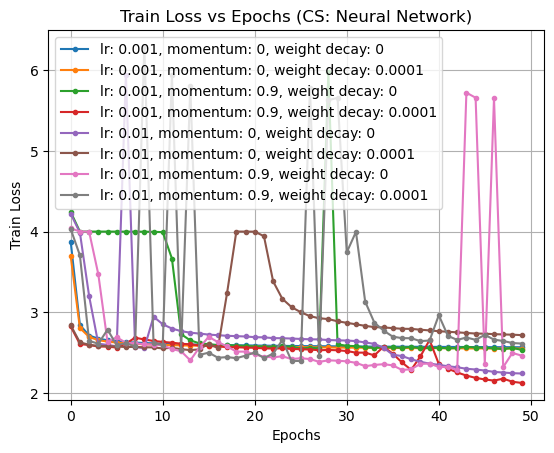

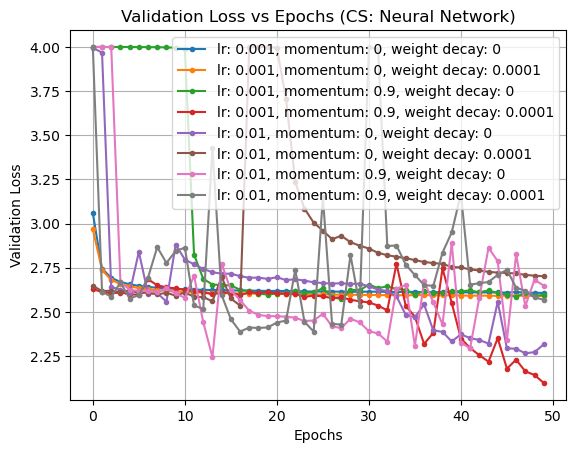

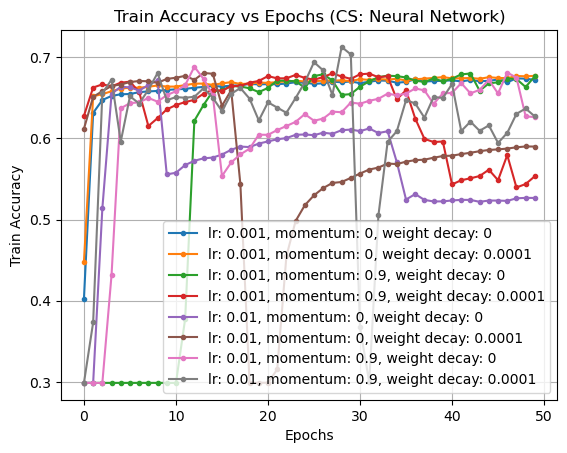

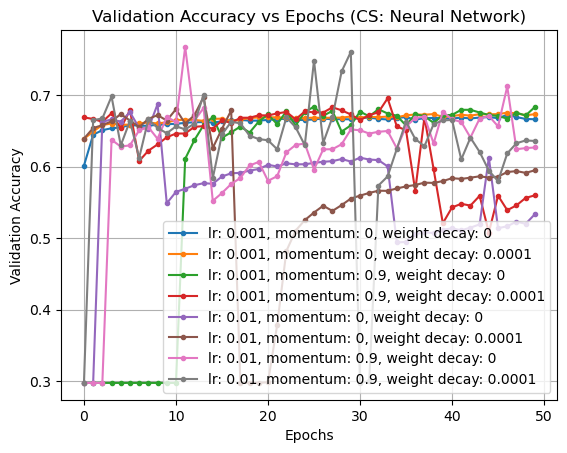

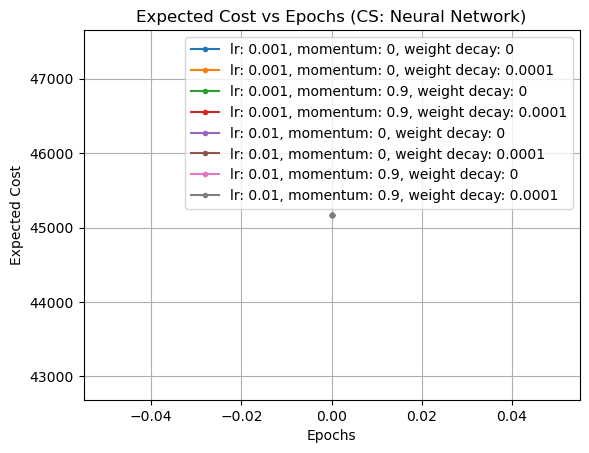

Best expected cost:  45169.30078339577
Best test accuracy:  0.6792910763673308
Best learning rate:  0.001
Best momentum:  0
Best weight decay:  0
Best test accuracy:  0.6792910763673308
Best expected cost:  45169.30078339577
Best learning rate:  0.001
Best momentum:  0
Best weight decay:  0


In [20]:
# select only first column of y_test
y_test_label = []
for i in range(len(y_test)):
    y_test_label.append(y_test[i][0])

lr_values = [0.001, 0.01]
momentum_values = [0, 0.9]
weight_decay_values = [0, 0.0001]

train_losses_list_nn_cs2 = []
val_losses_list_nn_cs2 = []
train_accuracies_list_nn_cs2 = []
val_accuracies_list_nn_cs2 = []
expected_costs_list_nn_cs2 = []
test_accuracy_list_nn_cs2 = []

for lr in lr_values:
    for momentum in momentum_values:
        for weight_decay in weight_decay_values:
            print("Learning Rate: ", lr)
            print("Momentum: ", momentum)
            print("Weight Decay: ", weight_decay)
            cost_sensitive_log_model = CostSensitiveNeuralNetwork(input_dim=X_train.shape[1], hidden_dim=20)
            
            optimizer = torch.optim.SGD(cost_sensitive_log_model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
            
            return_val = cost_sensitive_log_model.train_model2(train_loader, val_loader, optimizer=optimizer, num_epochs=50, learning_rate=lr)
            train_losses_cost_sensitive_lr, val_losses_cost_sensitive_lr, train_accuracies_cost_sensitive_lr, val_accuracies_cost_sensitive_lr, best_accuracy_cost_sensitive_lr, best_model_cost_sensitive_lr = return_val
            
            train_losses_list_nn_cs2.append(train_losses_cost_sensitive_lr)
            val_losses_list_nn_cs2.append(val_losses_cost_sensitive_lr)
            train_accuracies_list_nn_cs2.append(train_accuracies_cost_sensitive_lr)
            val_accuracies_list_nn_cs2.append(val_accuracies_cost_sensitive_lr)
            expected_costs_list_nn_cs2.append(cost_sensitive_log_model.compute_expected_cost(test_loader))
            y_pred = cost_sensitive_log_model(X_test)
            y_pred = y_pred >= 0.5
            y_pred = y_pred.detach().numpy()
            y_pred = y_pred.astype(int)
            y_pred = y_pred.tolist()
            test_accuracy_list_nn_cs2.append(accuracy_score(y_test_label, y_pred))

print(min(expected_costs_list_nn_cs2))
# plot train and validation loss for each hyperparameter combination
print(len(train_losses_list_nn_cs2))
# plt.figure(figsize=(20, 10))
plt.figure()
plt.grid()
for i in range(len(lr_values)):
    for j in range(len(momentum_values)):
        for k in range(len(weight_decay_values)):
            print(i*4 + j*2 + k, i, j, k)
            plt.plot(train_losses_list_nn_cs2[i*4 + j*2 + k], marker='.' ,label="lr: " + str(lr_values[i]) + ", momentum: " + str(momentum_values[j]) + ", weight decay: " + str(weight_decay_values[k]))
plt.legend()
plt.title("Train Loss vs Epochs (CS: Neural Network)")
plt.xlabel("Epochs")
plt.ylabel("Train Loss")
plt.show()

plt.figure()
plt.grid()
for i in range(len(lr_values)):
    for j in range(len(momentum_values)):
        for k in range(len(weight_decay_values)):
            plt.plot(val_losses_list_nn_cs2[i*4 + j*2 + k], marker='.' , label="lr: " + str(lr_values[i]) + ", momentum: " + str(momentum_values[j]) + ", weight decay: " + str(weight_decay_values[k]))
plt.legend()
plt.title("Validation Loss vs Epochs (CS: Neural Network)")
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.show()

# plot train and validation accuracy for each hyperparameter combination
plt.figure()
plt.grid()
for i in range(len(lr_values)):
    for j in range(len(momentum_values)):
        for k in range(len(weight_decay_values)):
            plt.plot(train_accuracies_list_nn_cs2[i*4 + j*2 + k], marker='.' , label="lr: " + str(lr_values[i]) + ", momentum: " + str(momentum_values[j]) + ", weight decay: " + str(weight_decay_values[k]))
plt.legend()
plt.title("Train Accuracy vs Epochs (CS: Neural Network)")
plt.xlabel("Epochs")
plt.ylabel("Train Accuracy")
plt.show()

plt.figure()
plt.grid()
for i in range(len(lr_values)):
    for j in range(len(momentum_values)):
        for k in range(len(weight_decay_values)):
            plt.plot(val_accuracies_list_nn_cs2[i*4 + j*2 + k], marker='.' , label="lr: " + str(lr_values[i]) + ", momentum: " + str(momentum_values[j]) + ", weight decay: " + str(weight_decay_values[k]))
plt.legend()
plt.title("Validation Accuracy vs Epochs (CS: Neural Network)")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.show()

# plot expected cost for each hyperparameter combination
plt.figure()
plt.grid()
for i in range(len(lr_values)):
    for j in range(len(momentum_values)):
        for k in range(len(weight_decay_values)):
            plt.plot(expected_costs_list_nn_cs2[i*4 + j*2 + k], marker='.' , label="lr: " + str(lr_values[i]) + ", momentum: " + str(momentum_values[j]) + ", weight decay: " + str(weight_decay_values[k]))
plt.legend()
plt.title("Expected Cost vs Epochs (CS: Neural Network)")
plt.xlabel("Epochs")
plt.ylabel("Expected Cost")
plt.show()

# plot test accuracy for each hyperparameter combination
plt.figure()
plt.grid()
for i in range(len(lr_values)):
    for j in range(len(momentum_values)):
        for k in range(len(weight_decay_values)):
            plt.plot(test_accuracy_list_nn_cs2[i*4 + j*2 + k], marker='.' , label="lr: " + str(lr_values[i]) + ", momentum: " + str(momentum_values[j]) + ", weight decay: " + str(weight_decay_values[k]))
plt.legend()
plt.title("Test Accuracy vs Epochs (CS: Neural Network)")
plt.xlabel("Epochs")
plt.ylabel("Test Accuracy")
plt.show()

# Print best expected cost and its accuracy and the model hyperparameters
best_expected_cost = min(expected_costs_list_nn_cs2)
best_expected_cost_index = expected_costs_list_nn_cs2.index(best_expected_cost)
best_test_accuracy = test_accuracy_list_nn_cs2[best_expected_cost_index]
best_lr = lr_values[best_expected_cost_index // 8]
best_momentum = momentum_values[(best_expected_cost_index % 8) // 4]
best_weight_decay = weight_decay_values[(best_expected_cost_index % 4) // 2]
print("Best expected cost: ", best_expected_cost)
print("Best test accuracy: ", best_test_accuracy)
print("Best learning rate: ", best_lr)
print("Best momentum: ", best_momentum)
print("Best weight decay: ", best_weight_decay)

# Print best accuracy and its expected cost and the model hyperparameters
best_test_accuracy = max(test_accuracy_list_nn_cs2)
best_test_accuracy_index = test_accuracy_list_nn_cs2.index(best_test_accuracy)
best_expected_cost = expected_costs_list_nn_cs2[best_test_accuracy_index]
best_lr = lr_values[best_test_accuracy_index // 8]
best_momentum = momentum_values[(best_test_accuracy_index % 8) // 4]
best_weight_decay = weight_decay_values[(best_test_accuracy_index % 4) // 2]
print("Best test accuracy: ", best_test_accuracy)
print("Best expected cost: ", best_expected_cost)
print("Best learning rate: ", best_lr)
print("Best momentum: ", best_momentum)
print("Best weight decay: ", best_weight_decay)

0 0 0 0
1 0 0 1
2 0 1 0
3 0 1 1
4 1 0 0
5 1 0 1
6 1 1 0
7 1 1 1


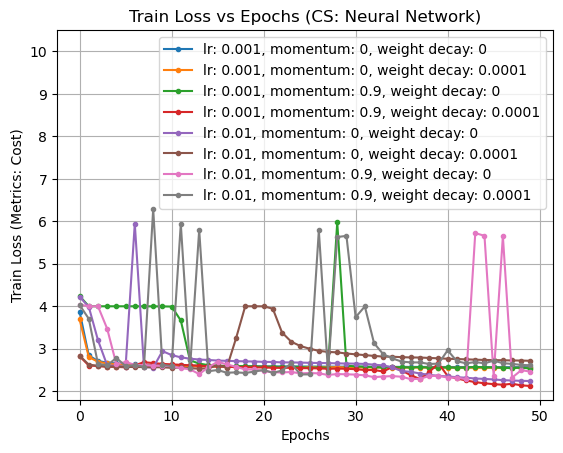

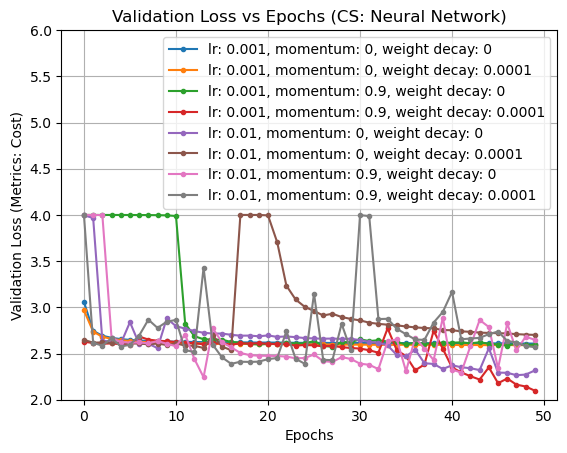

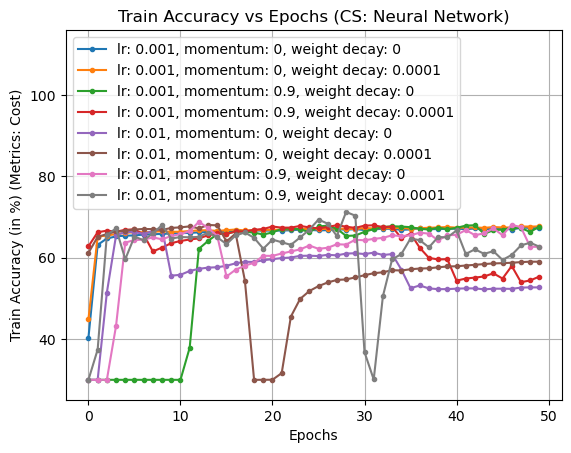

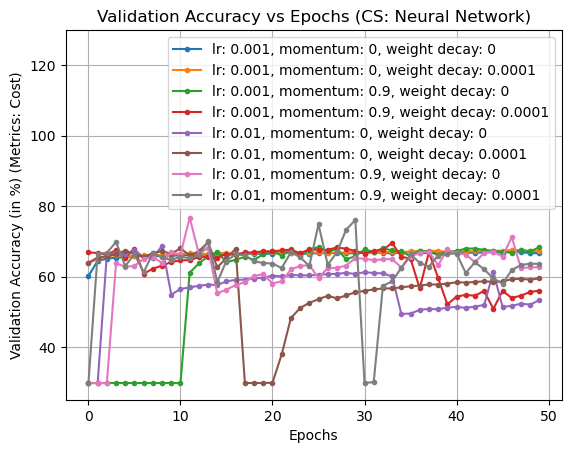

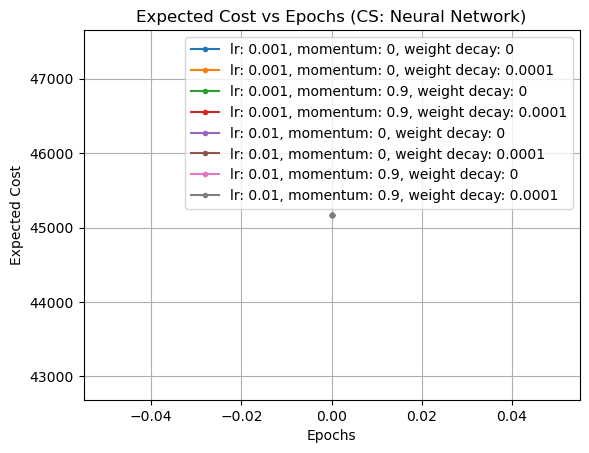

In [66]:
# fig, ax = plt.subplots()
# plt.grid()
# for i in range(len(lr_values)):
#     for j in range(len(momentum_values)):
#         for k in range(len(weight_decay_values)):
#             ax.plot(train_losses_list_nn_cs2[i*4 + j*2 + k], marker='.' , label="lr: " + str(lr_values[i]) + ", momentum: " + str(momentum_values[j]) + ", weight decay: " + str(weight_decay_values[k]))

# ax.set_xlabel('Epochs')
# ax.set_ylabel('Train Loss')
# ax.set_title('Train Loss vs Epochs (CS: Neural Network)')
# ax.set_ylim(1.8, 12)
# ax.legend(loc='upper left')
# plt.subplots_adjust(left=0.15, bottom=0.15)
# plt.show()

plt.figure()
plt.grid()
for i in range(len(lr_values)):
    for j in range(len(momentum_values)):
        for k in range(len(weight_decay_values)):
            print(i*4 + j*2 + k, i, j, k)
            plt.plot(train_losses_list_nn_cs2[i*4 + j*2 + k], marker='.' ,label="lr: " + str(lr_values[i]) + ", momentum: " + str(momentum_values[j]) + ", weight decay: " + str(weight_decay_values[k]))
plt.legend()
plt.title("Train Loss vs Epochs (CS: Neural Network)")
plt.xlabel("Epochs")
plt.ylabel("Train Loss (Metrics: Cost)")
plt.ylim(1.8, 10.5)
# plt.yticks(np.arange(1.8, 7, 0.5))
plt.show()

plt.figure()
plt.grid()
for i in range(len(lr_values)):
    for j in range(len(momentum_values)):
        for k in range(len(weight_decay_values)):
            plt.plot(val_losses_list_nn_cs2[i*4 + j*2 + k], marker='.' , label="lr: " + str(lr_values[i]) + ", momentum: " + str(momentum_values[j]) + ", weight decay: " + str(weight_decay_values[k]))
plt.legend()
plt.title("Validation Loss vs Epochs (CS: Neural Network)")
plt.xlabel("Epochs")
plt.ylabel("Validation Loss (Metrics: Cost)")
plt.ylim(2, 6)
plt.show()

# plot train and validation accuracy for each hyperparameter combination

# multiply by 100 to get percentage
# train_accuracies_list_nn_cs2 = [np.array(train_accuracies_list_nn_cs2[i]) * 100 for i in range(len(train_accuracies_list_nn_cs2))]

plt.figure()
plt.grid()
for i in range(len(lr_values)):
    for j in range(len(momentum_values)):
        for k in range(len(weight_decay_values)):
            plt.plot(train_accuracies_list_nn_cs2[i*4 + j*2 + k], marker='.' , label="lr: " + str(lr_values[i]) + ", momentum: " + str(momentum_values[j]) + ", weight decay: " + str(weight_decay_values[k]))
plt.legend(loc='upper left')
plt.title("Train Accuracy vs Epochs (CS: Neural Network)")
plt.xlabel("Epochs")
plt.ylabel("Train Accuracy (in %) (Metrics: Cost)")
plt.ylim(25, 116)
plt.show()

# multiply by 100 to get percentage
# val_accuracies_list_nn_cs2 = [np.array(val_accuracies_list_nn_cs2[i]) * 100 for i in range(len(val_accuracies_list_nn_cs2))]
plt.figure()
plt.grid()
for i in range(len(lr_values)):
    for j in range(len(momentum_values)):
        for k in range(len(weight_decay_values)):
            plt.plot(val_accuracies_list_nn_cs2[i*4 + j*2 + k], marker='.' , label="lr: " + str(lr_values[i]) + ", momentum: " + str(momentum_values[j]) + ", weight decay: " + str(weight_decay_values[k]))
plt.legend()
plt.title("Validation Accuracy vs Epochs (CS: Neural Network)")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy (in %) (Metrics: Cost)")
plt.ylim(25, 130)
plt.show()

# plot expected cost for each hyperparameter combination
plt.figure()
plt.grid()
for i in range(len(lr_values)):
    for j in range(len(momentum_values)):
        for k in range(len(weight_decay_values)):
            plt.plot(expected_costs_list_nn_cs2[i*4 + j*2 + k], marker='.' , label="lr: " + str(lr_values[i]) + ", momentum: " + str(momentum_values[j]) + ", weight decay: " + str(weight_decay_values[k]))
plt.legend()
plt.title("Expected Cost vs Epochs (CS: Neural Network)")
plt.xlabel("Epochs")
plt.ylabel("Expected Cost")
plt.show()

# plot test accuracy for each hyperparameter combination
plt.figure()
plt.grid()
for i in range(len(lr_values)):
    for j in range(len(momentum_values)):
        for k in range(len(weight_decay_values)):
            plt.plot(test_accuracy_list_nn_cs2[i*4 + j*2 + k], marker='.' , label="lr: " + str(lr_values[i]) + ", momentum: " + str(momentum_values[j]) + ", weight decay: " + str(weight_decay_values[k]))
plt.legend()
plt.title("Test Accuracy vs Epochs (CS: Neural Network)")
plt.xlabel("Epochs")
plt.ylabel("Test Accuracy")
plt.show()

In [53]:
cost_sensitive_nn = CostSensitiveNeuralNetwork(input_dim=X_train.shape[1], hidden_dim=20)
return_val = cost_sensitive_nn.train_model(train_loader, test_loader, num_epochs=10, learning_rate=0.001)
print("Cost of Cost Sensitive Neural Network: ", cost_sensitive_nn.compute_expected_cost(test_loader))

# Display confusion matrix
y_pred = cost_sensitive_nn(X_test)
y_pred = y_pred >= 0.5
y_pred = y_pred.detach().numpy()
y_pred = y_pred.astype(int)

# select only first column of y_test
y_test_label = []
for i in range(len(y_test)):
    y_test_label.append(y_test[i][0])

# convert y_pred and y_test into list
y_pred = y_pred.tolist()
# y_test = y_test.tolist()
# print precision, recall, f1 score
print(classification_report(y_test_label, y_pred))

# print accuracy
print("Accuracy: ", accuracy_score(y_test_label, y_pred))

Epoch: 1 	Training Loss: 9.026176 	Training Accuracy: 0.301834 	Validation Loss: 3.573717 	Validation Accuracy: 0.297074
Epoch: 2 	Training Loss: 3.477487 	Training Accuracy: 0.542465 	Validation Loss: 2.759674 	Validation Accuracy: 0.665944
Epoch: 3 	Training Loss: 2.785147 	Training Accuracy: 0.668218 	Validation Loss: 2.673012 	Validation Accuracy: 0.652036
Epoch: 4 	Training Loss: 2.644423 	Training Accuracy: 0.666496 	Validation Loss: 2.646624 	Validation Accuracy: 0.654339
Epoch: 5 	Training Loss: 2.602388 	Training Accuracy: 0.667067 	Validation Loss: 2.632211 	Validation Accuracy: 0.656371
Epoch: 6 	Training Loss: 2.578712 	Training Accuracy: 0.670182 	Validation Loss: 2.619107 	Validation Accuracy: 0.661293
Epoch: 7 	Training Loss: 2.830965 	Training Accuracy: 0.673695 	Validation Loss: 2.600717 	Validation Accuracy: 0.670821
Epoch: 8 	Training Loss: 3.058951 	Training Accuracy: 0.678369 	Validation Loss: 2.595115 	Validation Accuracy: 0.666712
Epoch: 9 	Training Loss: 2.56871